##### Config

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

In [4]:
del matplotlib; del plt; del warnings

##### Main

I ran into an interesting statistics problem while working on my interpretable Gaussian process for stellar light curves (see <a href='2020-10-01.html'>this post</a>). What happens to the covariance structure of a dataset when we normalize it to its own mean (or median)? This is something that happens a lot in the literature: astronomers love normalizing light curves to sweep the unknown baseline under the rug and convert their data in relative units. But it turns out that this is sometimes a dangerous thing to do, since it can significantly change the covariance structure of the data. In this post I'll show an example of this, how it can bias GP inference, and how to fix it.

This post was generated from [this Jupyter notebook](notebooks/NormalizedGP.ipynb) and [this helper Python script](notebooks/normgp.py).

# The premise

It is standard practice in astronomy to mean- or median- normalize datasets,
since one is often more interested in deviations from
some baseline than in the value of the baseline itself. This is the case,
for example, in searches for transiting exoplanets or photometric studies
of stellar variability, where the raw data
consists of a timeseries of fluxes measured in counts on the detector.
The absolute number of counts from a particular target is physically
uninteresting, as it depends on a host of variables such as the distance to
the target, the collecting area of the instrument, and the quantum efficiency of the
detector. However, fractional deviations from the mean number of counts
*are* physically meaningful, as they can encode information such as the
size of the transiting planet or the size and contrast of star spots.
Normalization by the mean (or median) allows one to analyze data in units of (say)
parts per million rather than counts per second.

Another common practice in astronomy is to model one's data (or at least
a component of one's data) as a Gaussian process (GP).
GPs offer a convenient, flexible, and efficient way of modeling correlated
data and have seen extensive use in both transiting exoplanet and stellar
variability studies. In one dimension, a GP is fully described
by a mean vector $\pmb{\mu}$ and a covariance matrix $\pmb{\Sigma}$, the
latter of which encodes information about correlations and periodicities
in the data that are in some cases related to physical
parameters of interest (such as the rotation period of a star or the
lifetime of star spots).

In this post, I'm going to show that these two common practices can be somewhat at odds
with each other. Specifically, if a physical process that generates
a dataset is distributed as a GP, the normalized process *cannot* be
distributed as a GP. Provided certain conditions are met, the normalized
process can be well *approximated* by a GP, albeit one with a different
covariance matrix $\tilde{\pmb{\Sigma}}$ that is not simply a scalar
multiple of the original covariance matrix. Moreover, if the original process
is described by a stationary kernel (i.e., one in which covariances are
independent of phase), the normalized process is not guaranteed to be.

For most applications, none of this is likely to make
much of a difference, since GPs are often used to model nuisance
signals; in that case, the optimal hyperparameters describing the GP
covariance are physically uninteresting. However, in cases where one
wishes to interpret the GP hyperparameters in a physical context
(such as using a periodic GP kernel to infer stellar rotation rates),
normalizing one's data to the mean or median value can impart
(potentially significant) bias. This can usually be fixed in a **very simple**
way: just fit for the baseline, even if you think you know what it should be!

This post is only the beginning of my musings on the topic. I'm (very slowly)
writing a paper on this [here](https://github.com/rodluger/normgp), and I hope
to go in more depth in future posts.

# Setup

To show the issue with normalizing data, let's generate a synthetic dataset. We're going to keep things simple and generate datasets from a sinusoidal model with a fixed amplitude and period but a random phase, plus some Gaussian noise with known variance. We can pretend each dataset is a light curve of a star $-$ a set of measurements of the star's flux over time. We will then "observe" these data and model it using a periodic Gaussian process, and check whether this GP serves as a good estimator (unbiased, well calibrated) for the period.

In order to gauge any bias in the estimate, we need to generate **many** datasets. Again, they will all be generated from sinusoids with the same amplitude and period, but with random phases and random Gaussian noise.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george.kernels import CosineKernel
import scipy.optimize as op
from tqdm.auto import tqdm
from scipy.stats import norm
import normgp
import theano
import theano.tensor as tt
from IPython.display import display, Markdown

Here are the settings we'll adopt for this experiment:

In [6]:
npts = 300
ndatasets = 1000
mean = 1.0
sigma = 0.01
tmax = 1.0
amp_true = 0.1
p_true = 0.93427
t = np.linspace(0, tmax, npts)

In [7]:
display(Markdown(f"""
| setting | description | value |
| - | :- | :-:
| `npts` | number of points per dataset | `{npts}` |
| `ndatasets` | number of datasets | `{ndatasets}`|
| `mean` | mean of the generating process | `{mean}` |
| `sigma` | uncertainty on each data point | `{sigma}` |
| `tmax` | independent variable runs from `0` to this value | `{tmax}` |
| `amp_true` | true amplitude of the process | `{amp_true}` |
| `p_true` | true period of the process | `{p_true}` |
"""))


| setting | description | value |
| - | :- | :-:
| `npts` | number of points per dataset | `300` |
| `ndatasets` | number of datasets | `1000`|
| `mean` | mean of the generating process | `1.0` |
| `sigma` | uncertainty on each data point | `0.01` |
| `tmax` | independent variable runs from `0` to this value | `1.0` |
| `amp_true` | true amplitude of the process | `0.1` |
| `p_true` | true period of the process | `0.93427` |


Note that the period is slightly less than the baseline over which we're making the measurements, meaning that in each dataset we're observing slightly *more* than one period. As we will see, this is precisely the scenario in which GP inference on *normalized* data can lead to bias.

# Standard data

First, let's run our experiment on the actual raw data, meaning we won't do any normalization. (So this better work!)

## Generate the data

Let's generate ``ndatasets`` datasets with different realizations of the noise. Each dataset is simply a sine curve with amplitude ``amp_true``, period ``p_true``, and a random phase, plus Gaussian noise with standard deviation ``sigma``.

In [8]:
np.random.seed(0)
y_true = mean + amp_true * np.sin(
    2 * np.pi / p_true * t.reshape(1, -1) + 2 * np.pi * np.random.random(size=(ndatasets, 1))
)
y = y_true + sigma * np.random.randn(ndatasets, npts)

We can plot a few of them to see what we're dealing with:

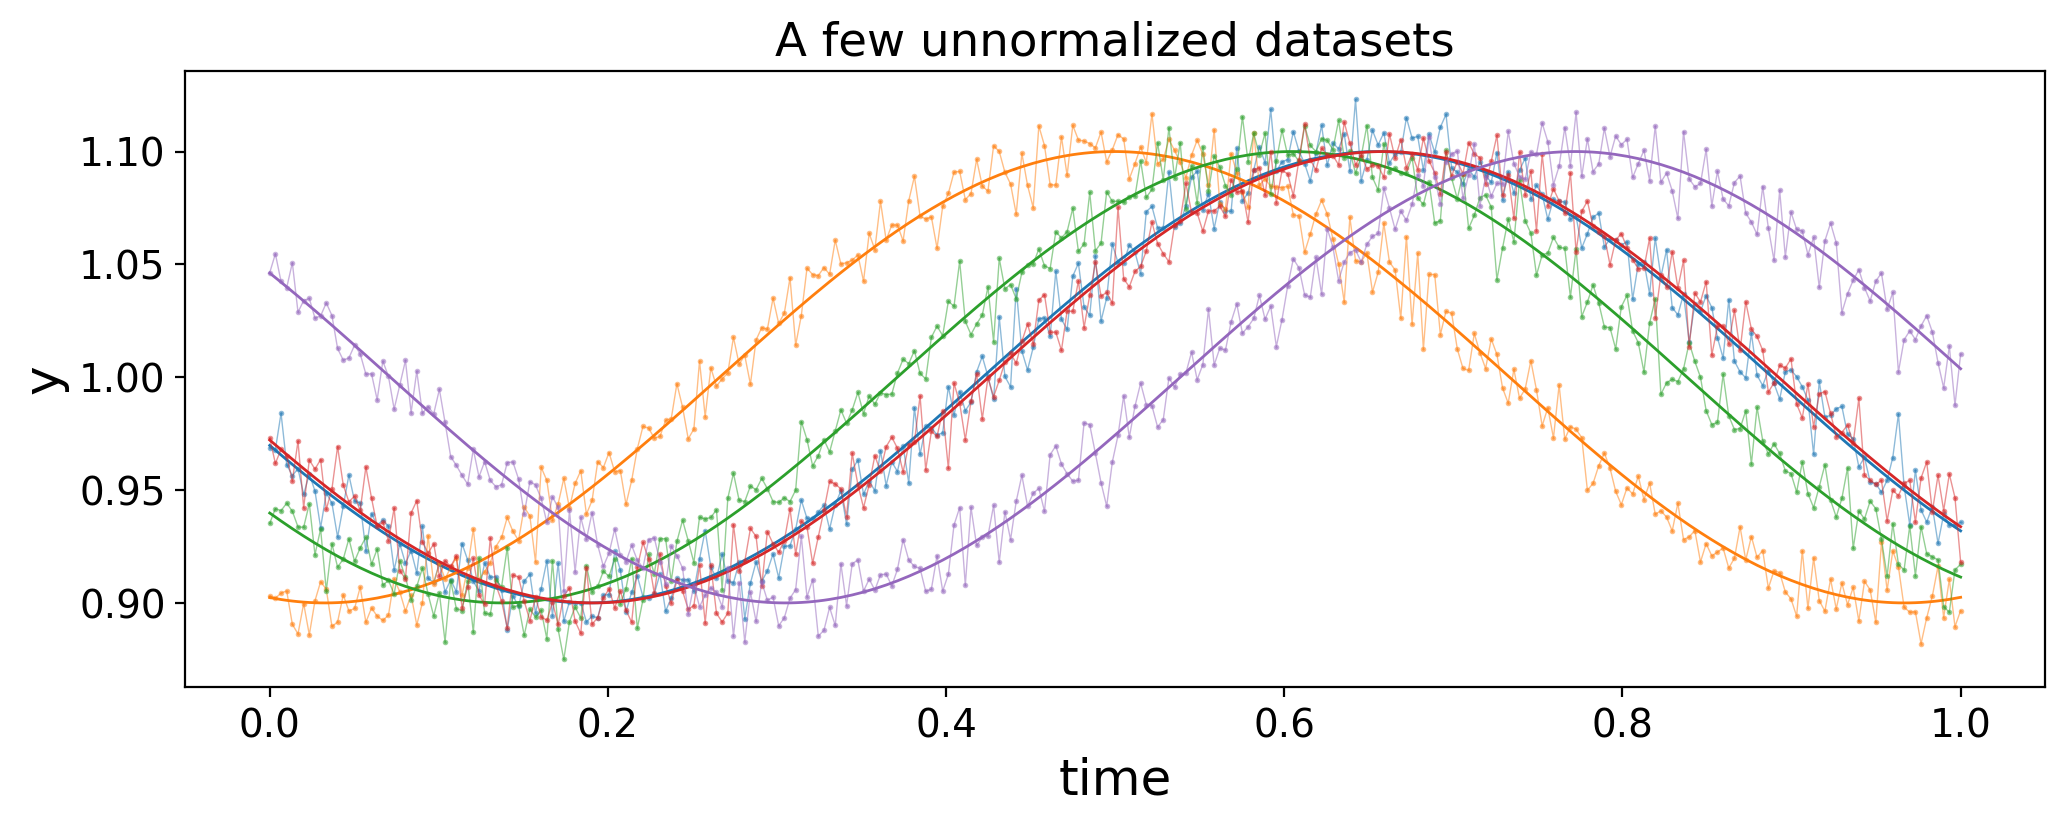

In [9]:
for m in range(5):
    plt.plot(t, y_true[m], lw=1, color="C{}".format(m))
    plt.plot(t, y[m], lw=0.5, alpha=0.5, color="C{}".format(m))
    plt.plot(t, y[m], ".", ms=2, alpha=0.5, color="C{}".format(m))
plt.xlabel("time", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.title("A few unnormalized datasets");

The thicker lines are the sine curves and the thinner lines (and points) are the noisy data we observe.

## Inference using a cosine kernel

Our task now is to infer the period of the sinusoid from each dataset using a periodic Gaussian process. We'll use the perfectly periodic ``CosineKernel`` and its implementation in the ``george`` package to compute the likelihood. Since we're going to run inference on a bunch of datasets, we're going to cut some corners and just *optimize* the parameters to find the maximum likelihood period and amplitude. We will then estimate the posterior variance as the negative reciprocal of the second derivative of the log-likelihood at this value (this is called the Laplace approximation). Note that we also have to optimize the amplitude of the GP, but for simplicity we'll just fix that at the maximum likelihood value when computing the posterior uncertainty on the period. (If you're concerned about any of this, see below: this turns out to be a very good approximation to the posterior for this particular problem).

In [10]:
p_mean_george = np.empty(ndatasets)
p_std_george = np.empty(ndatasets)


def nll(x, data):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    ll = gp.log_likelihood(data, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(x, data):
    """Return the gradient of the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    return -gp.grad_log_likelihood(data, quiet=True)


# Initial guesses (log amp^2, log period)
guess = [np.log(amp_true ** 2 / 2), np.log(p_true)]

# Set up the periodic GP
gp = george.GP(
    np.exp(guess[0]) * CosineKernel(guess[1]), white_noise=np.log(sigma ** 2), mean=mean
)
gp.compute(t)

# Run the optimizer on each dataset
for m in tqdm(range(ndatasets)):

    # Find the period at max likelihood
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(y[m],))
    _, p_mean_george[m] = np.exp(results.x)

    # Laplace approximation to get the local posterior std. dev.
    eps = 1e-8 * grad_nll(results.x, y[m])[1]
    p_std_george[m] = np.sqrt(
        (2 * eps)
        / (
            grad_nll(results.x + np.array([0.0, eps]), y[m])[1]
            - grad_nll(results.x - np.array([0.0, eps]), y[m])[1]
        )
    )

Here is the distribution of maximum likelihood estimates of the period for the inference runs on each of our ``ndatasets`` datasets:

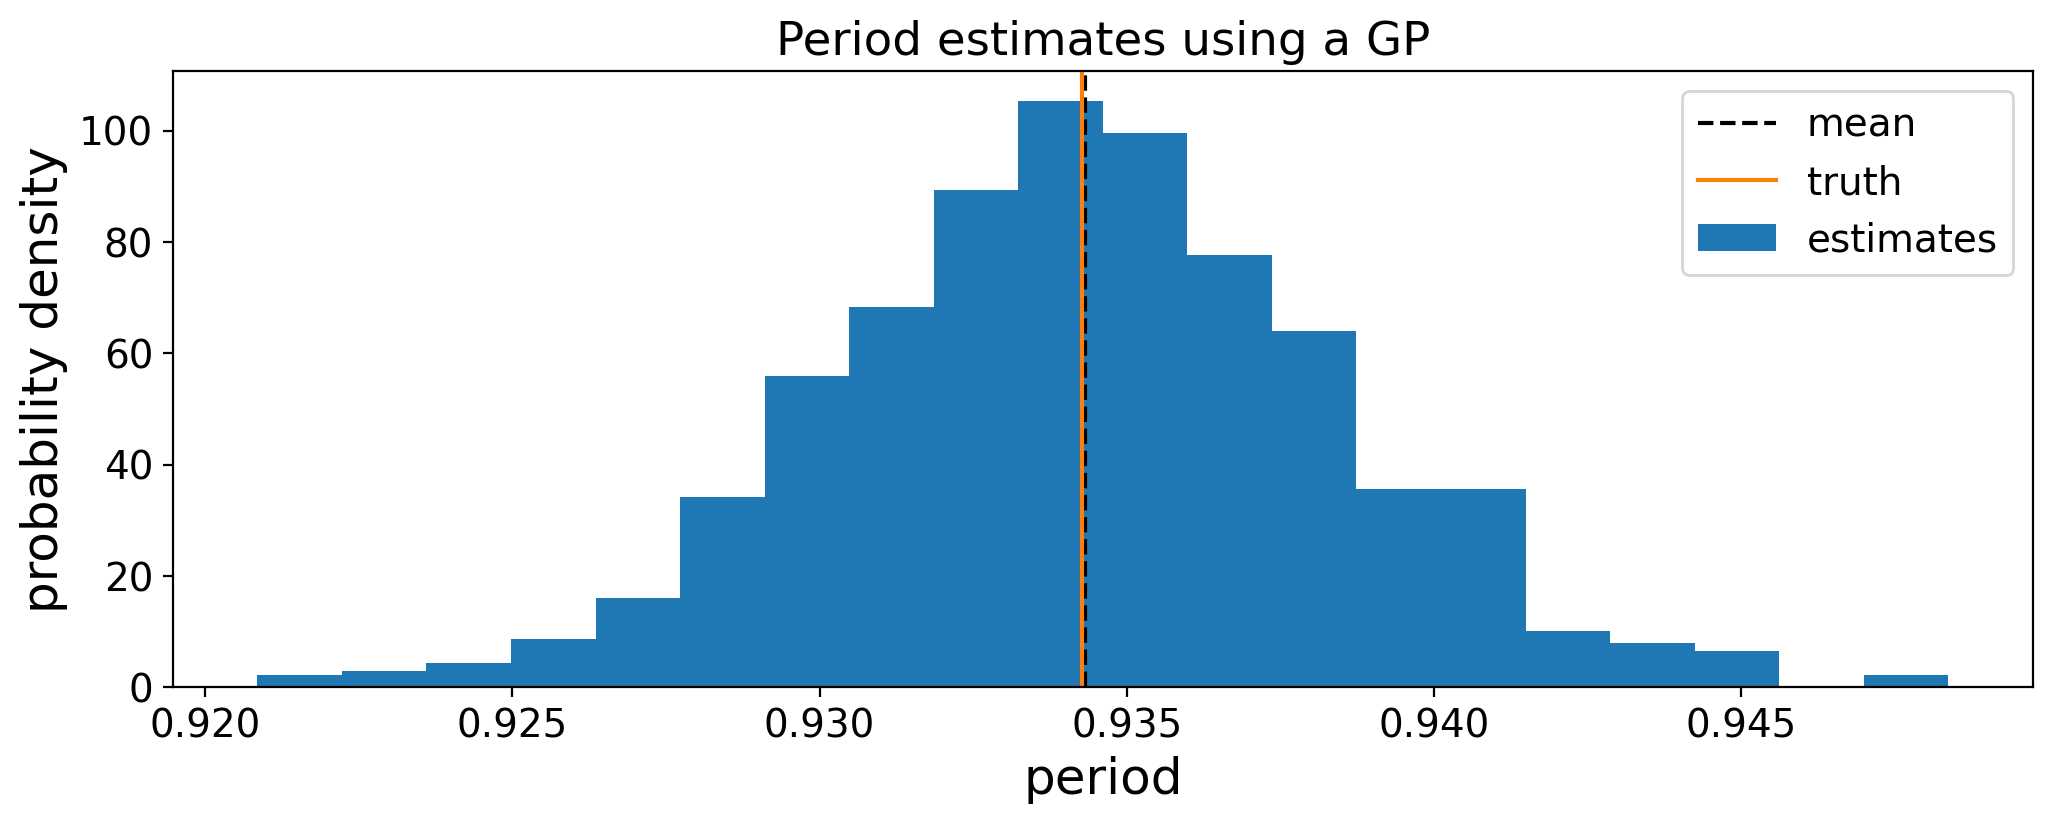

In [11]:
plt.hist(p_mean_george, bins=20, density=True, label="estimates")
plt.axvline(np.mean(p_mean_george), color="k", ls="--", label="mean");
plt.axvline(p_true, color="C1", label="truth")
plt.xlabel("period", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.legend()
plt.title("Period estimates using a GP");

The orange line is the true period, ``p_true``, and the dashed black line is the mean of the distribution of posterior means. The fact that these coincide (and that the distribution is approximately Gaussian) means that our procedure for estimating the period is unbiased.

We can also check if our method correctly estimates the posterior *variance*. To do this, we can compare our distribution of residuals,

$$
r_n \equiv \frac{\mu_n - p_\mathrm{true}}{\sigma_n}
$$

to a standard normal distribution. In the expression above, $\mu_n$ is the period posterior mean and $\sigma_n$ is the period posterior standard deviation for the $m^\mathrm{th}$ dataset. If our method is well calibrated, we would expect that something like 68% of our posterior means should lie within one posterior standard deviation of the true value, 95% should like within two posterior standard deviations of the true value, and so forth. This is equivalent to checking whether the residuals $r_n$ defined above follow a zero-mean Gaussian distribution with unit standard deviation.

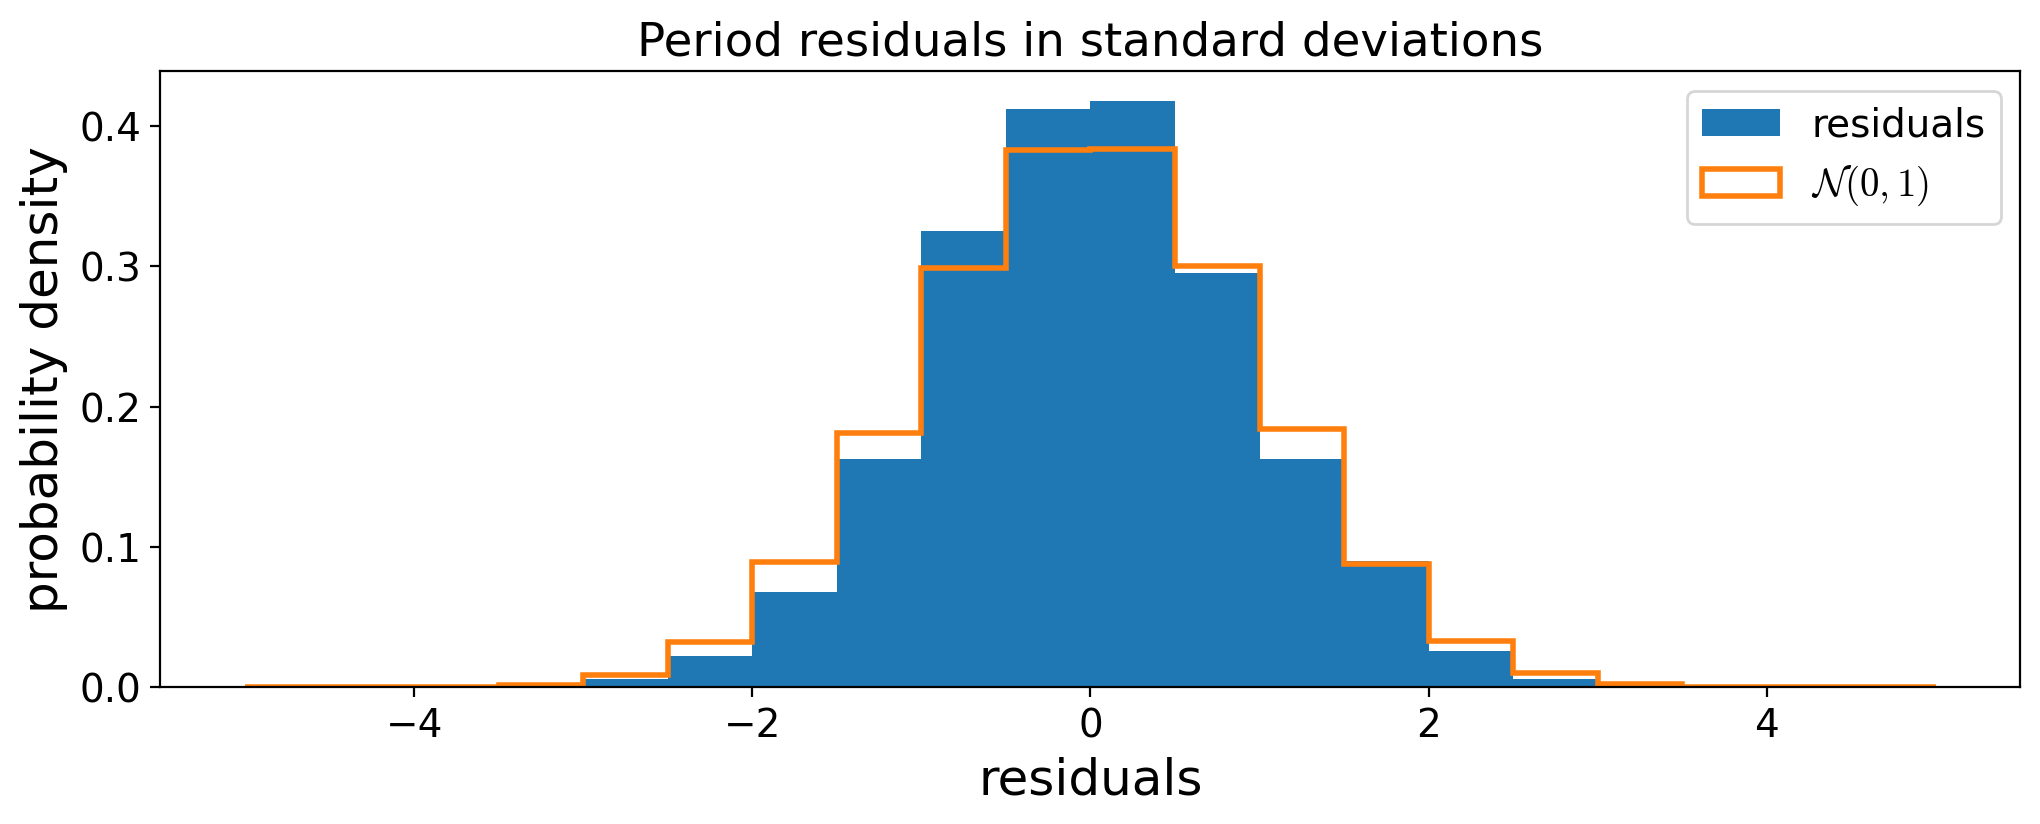

In [12]:
resid = (p_mean_george - p_true) / p_std_george
plt.hist(resid, bins=20, density=True, range=(-5, 5), label="residuals")
plt.hist(
    norm.rvs(size=100000),
    bins=20,
    density=True,
    histtype="step",
    lw=2,
    range=(-5, 5),
    label=r"$\mathcal{N}(0, 1)$"
)
plt.legend()
plt.xlabel("residuals", fontsize=18);
plt.ylabel("probability density", fontsize=18)
plt.title("Period residuals in standard deviations");

The blue distribution is the distribution of residuals, and the orange distribution is the standard normal. It's a pretty close match, so our method is in fact well calibrated! We may therefore conclude (without too much attention to rigor) that

<style>
.isa_info {
    margin: 10px 0px;
    padding: 12px;
 
}
.isa_info {
    color: #00529B;
    background-color: #BDE5F8;
    font-size:1.25em;
    border-radius: 2px;
}
</style>

<div class="isa_info">
    The period of a periodic GP is an unbiased estimate of the period of a sinusoid.
</div>

## Inference using our implementation

Below we repeat the inference step above, but using our custom implementation of the likelihood function. It's identical to the ``george`` implementation in all respects -- we're only doing this as a check. Later, we will use our implementation again, but with the ``normalized`` flag set to ``True`` to model a *normalized* Gaussian process. We'll comment on what we're doing in more detail at that point.

In [13]:
x_ = tt.dvector()
y_ = tt.dvector()
get_ll = theano.function([x_, y_], normgp.log_likelihood(x_, t, y_, mean=mean, sigma=sigma, normalized=False))
get_grad_ll = theano.function(
    [x_, y_],
    tt.grad(normgp.log_likelihood(x_, t, y_, mean=mean, sigma=sigma, normalized=False), x_)
)

In [14]:
p_mean_luger = np.empty(ndatasets)
p_std_luger = np.empty(ndatasets)


def nll(x, data):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    ll = get_ll(x, data)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(x, data):
    """Return the gradient of the negative log likelihood of ``data`` conditioned on params ``x``."""
    return -get_grad_ll(x, data)


# Initial guesses
guess = [np.log(amp_true ** 2 / 2), np.log(p_true)]

# Run the optimizer on each dataset
for m in tqdm(range(ndatasets)):

    # Find the period at max likelihood
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(y[m],))
    _, p_mean_luger[m] = np.exp(results.x)

    # Laplace approximation to get the local posterior std. dev.
    eps = 1e-8 * grad_nll(results.x, y[m])[1]
    p_std_luger[m] = np.sqrt(
        (2 * eps)
        / (
            grad_nll(results.x + np.array([0.0, eps]), y[m])[1]
            - grad_nll(results.x - np.array([0.0, eps]), y[m])[1]
        )
    )

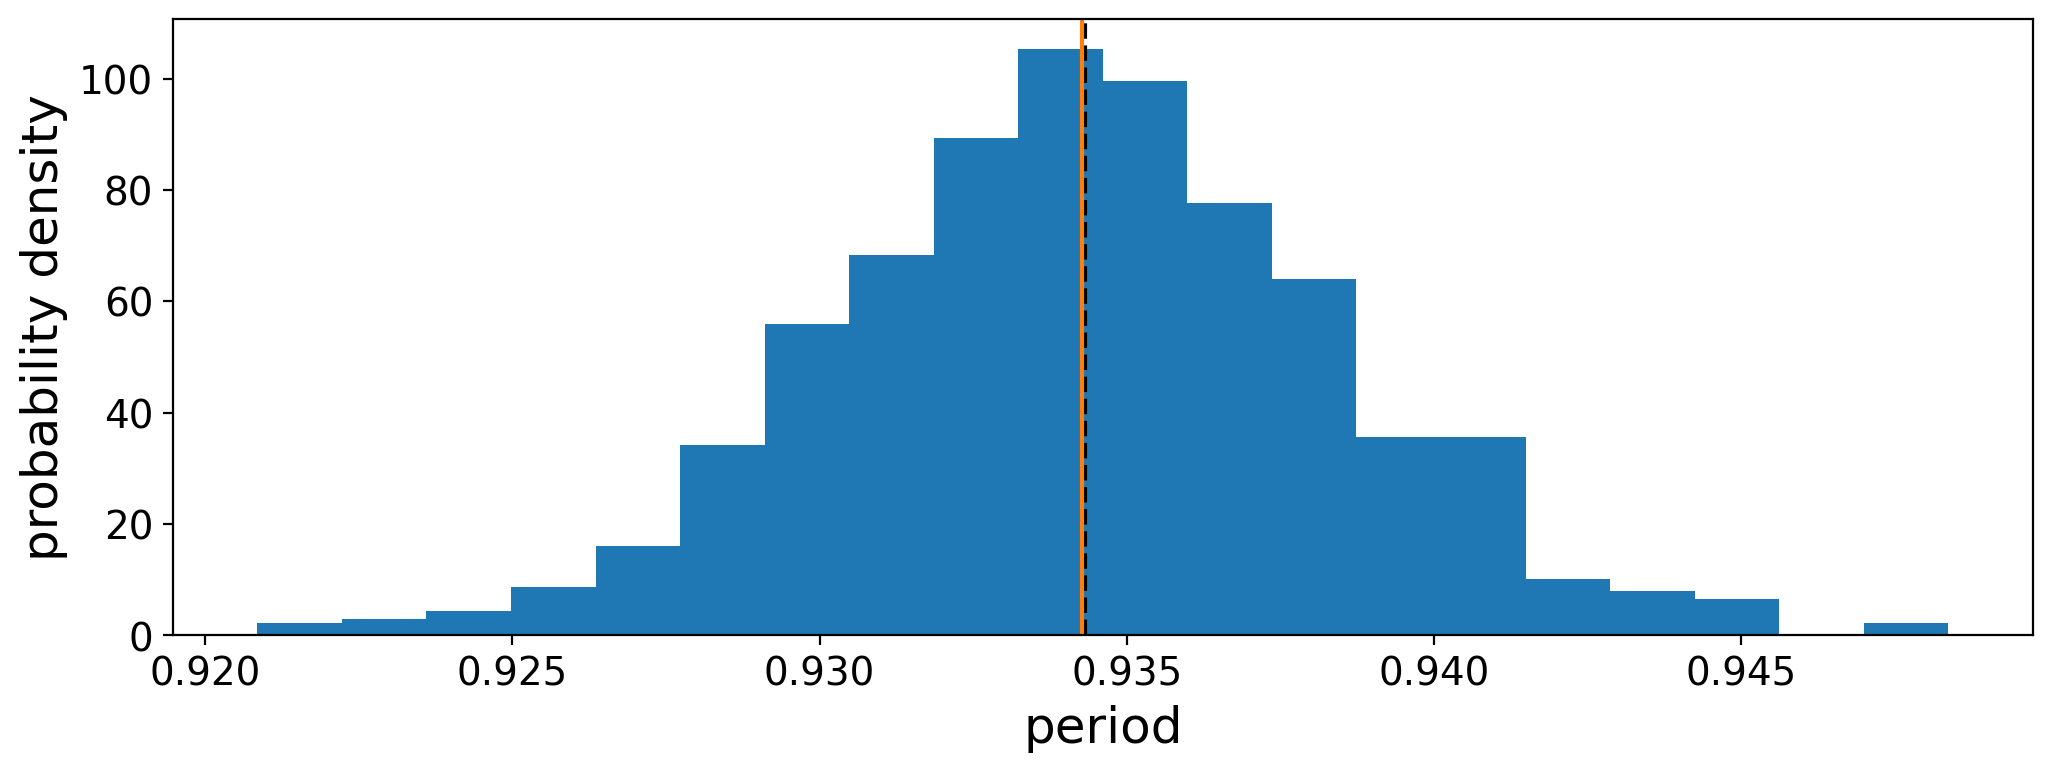

In [15]:
plt.hist(p_mean_luger, bins=20, density=True)
plt.axvline(np.mean(p_mean_luger), color="k", ls="--");
plt.axvline(p_true, color="C1")
plt.xlabel("period", fontsize=18)
plt.ylabel("probability density", fontsize=18);

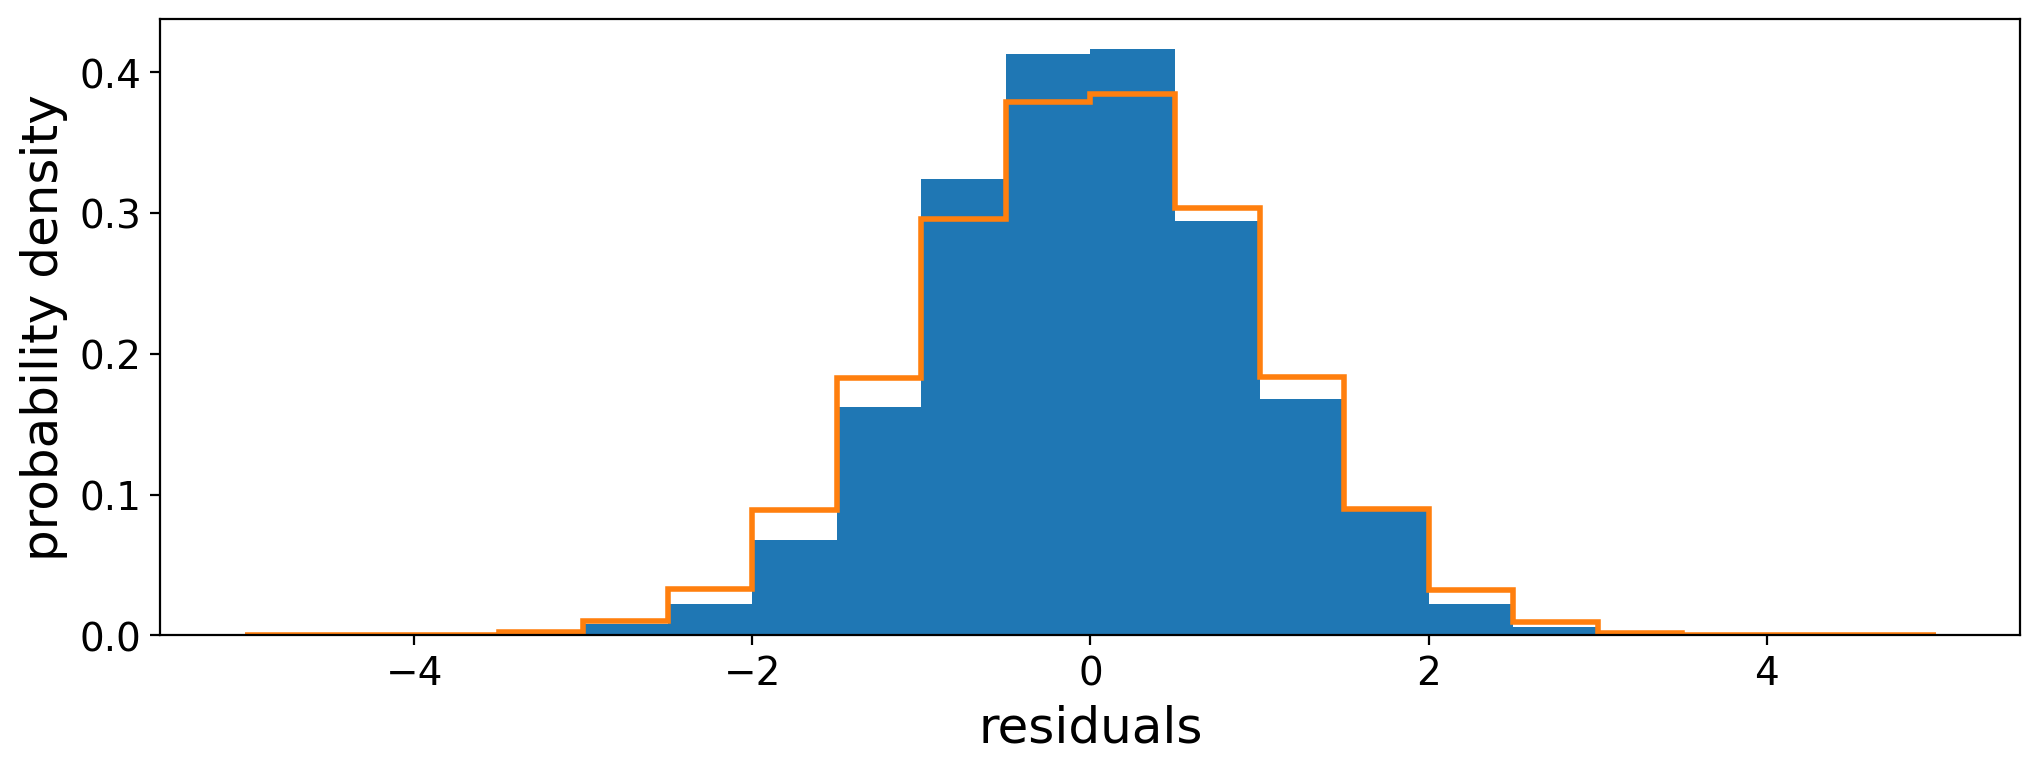

In [16]:
resid = (p_mean_luger - p_true) / p_std_luger
plt.hist(resid, bins=20, density=True, range=(-5, 5))
plt.hist(
    norm.rvs(size=100000),
    bins=20,
    density=True,
    histtype="step",
    lw=2,
    range=(-5, 5),
)
plt.xlabel("residuals", fontsize=18);
plt.ylabel("probability density", fontsize=18);

# Normalized data

Now let's do something slightly different. We'll use the exact same dataset, but before we do inference, we're going to do one seemingly innocent thing: normalize the data. It's something we've all probably done (astronomers in particular love doing it), probably without thinking twice. 

Specifically, if `y` is the dataset (our measurements at each point in time `t`), we will compute

$$
\tilde{y} = \frac{y}{<y>}
$$

In other words, we divide each dataset by its own (empirical) mean. If we're being careful about propagation of errors, we also need to normalize our uncertainty in the same way:

$$
\tilde{\sigma} = \frac{\sigma}{<y>}
$$

Note that we could instead choose to normalize by the *median* of the dataset, in which case all of the stuff below still applies (try it out in the [notebook](notebooks/NormalizedGP.ipynb) if you're interested).

## Generate the data

In [17]:
ymean = np.mean(y, axis=1)  
ynorm = y / ymean.reshape(-1, 1)                     
sigmanorm = sigma / ymean

Here are the same five datasets as before, but this time after the normalization has been applied.

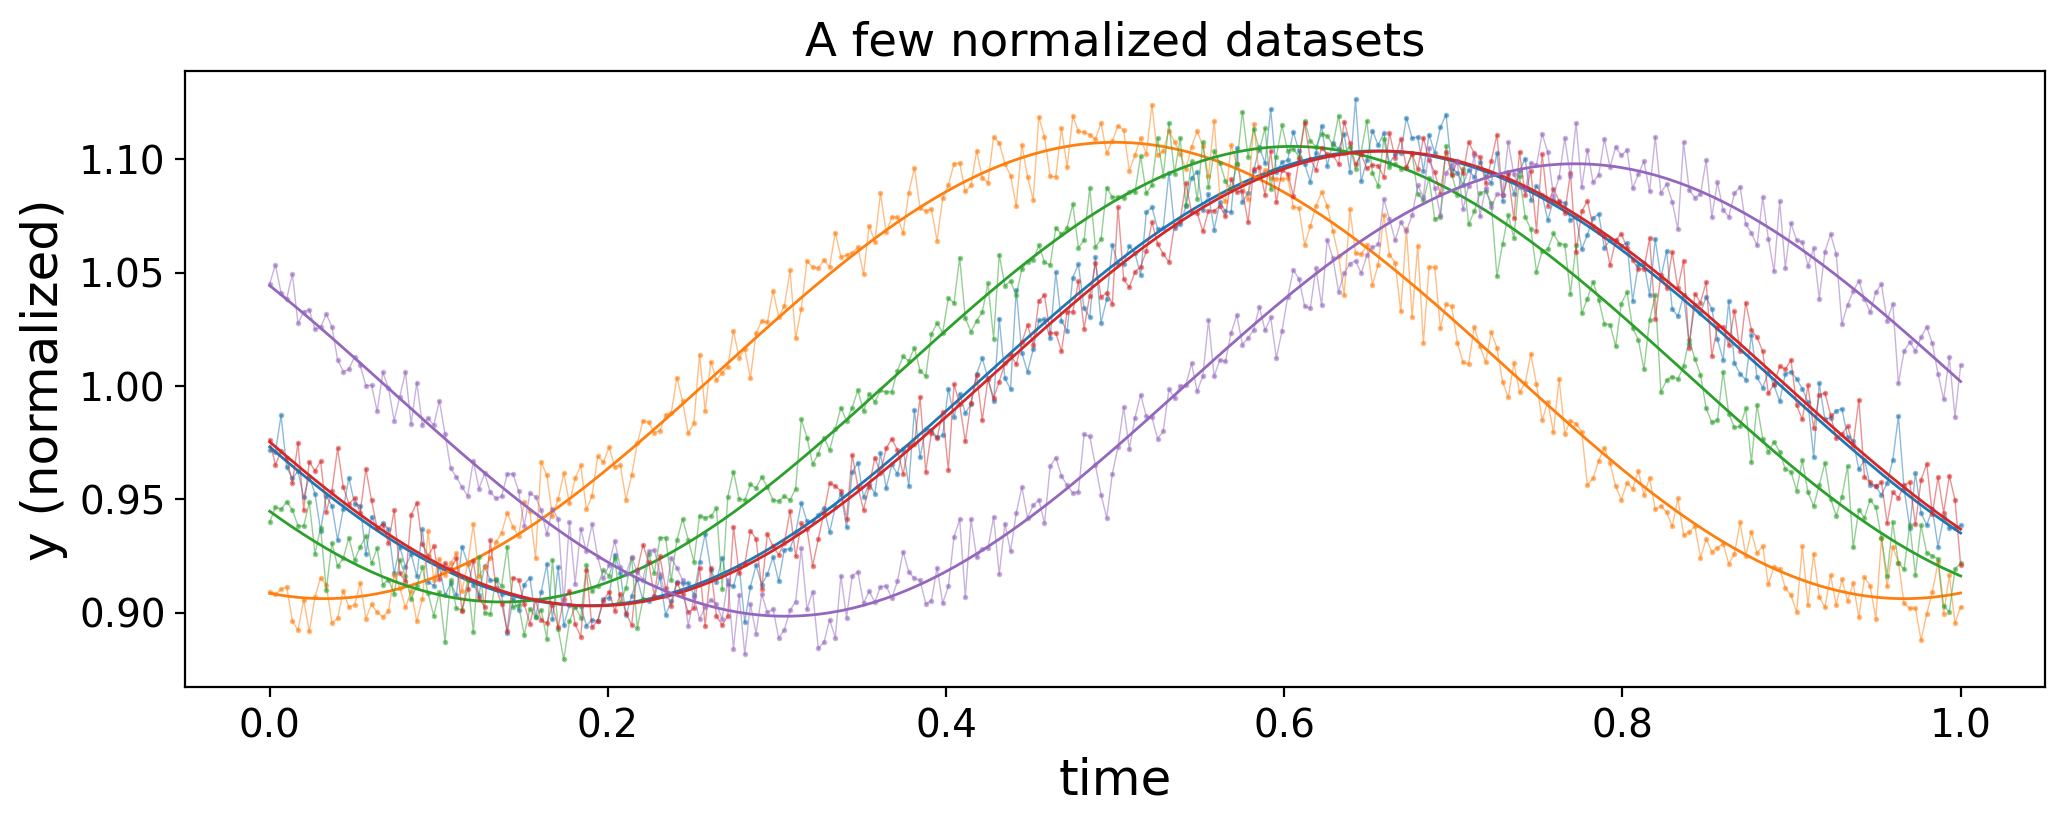

In [18]:
for m in range(5):
    plt.plot(t, y_true[m] / np.mean(y_true[m]), lw=1, color="C{}".format(m))
    plt.plot(t, ynorm[m], lw=0.5, alpha=0.5, color="C{}".format(m))
    plt.plot(t, ynorm[m], ".", ms=2, alpha=0.5, color="C{}".format(m))
plt.xlabel("time", fontsize=18)
plt.ylabel("y (normalized)", fontsize=18)
plt.title("A few normalized datasets");

To the eye, they look pretty much identical. But they are not *exactly* the same: the mean of each individual light curve is *slightly* different from the mean of the process (because of random noise and the fact that we're not observing an integer number of cycles of the sinusoid).

Let's see how this affects our inference below.

## Inference using a cosine kernel

We'll run the same inference procedure as above, this time on the normalized data. We'll be careful and use the normalized uncertainty as the white noise component of the GP, and note that the normalization step means our new GP mean is *identically* one.

In [19]:
p_mean_george_norm = np.empty(ndatasets)
p_std_george_norm = np.empty(ndatasets)


def nll(x, data):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    ll = gp.log_likelihood(data, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(x, data):
    """Return the gradient of the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    return -gp.grad_log_likelihood(data, quiet=True)


# Initial guesses (log amp^2, log period)
guess = [np.log(amp_true ** 2 / 2), np.log(p_true)]


# Run the optimizer on each dataset
for m in tqdm(range(ndatasets)):

    # Set up the periodic GP
    gp = george.GP(
        np.exp(guess[0]) * CosineKernel(guess[1]), white_noise=np.log(sigmanorm[m] ** 2), mean=1.0
    )
    gp.compute(t)
    
    # Find the period at max likelihood
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(ynorm[m],))
    _, p_mean_george_norm[m] = np.exp(results.x)
    
    # Laplace approximation to get the local posterior std. dev.
    eps = 1e-8 * grad_nll(results.x, ynorm[m])[1]
    p_std_george_norm[m] = np.sqrt(
        (2 * eps)
        / (
            grad_nll(results.x + np.array([0.0, eps]), ynorm[m])[1]
            - grad_nll(results.x - np.array([0.0, eps]), ynorm[m])[1]
        )
    )

Here is the distribution of maximum likelihood period values:

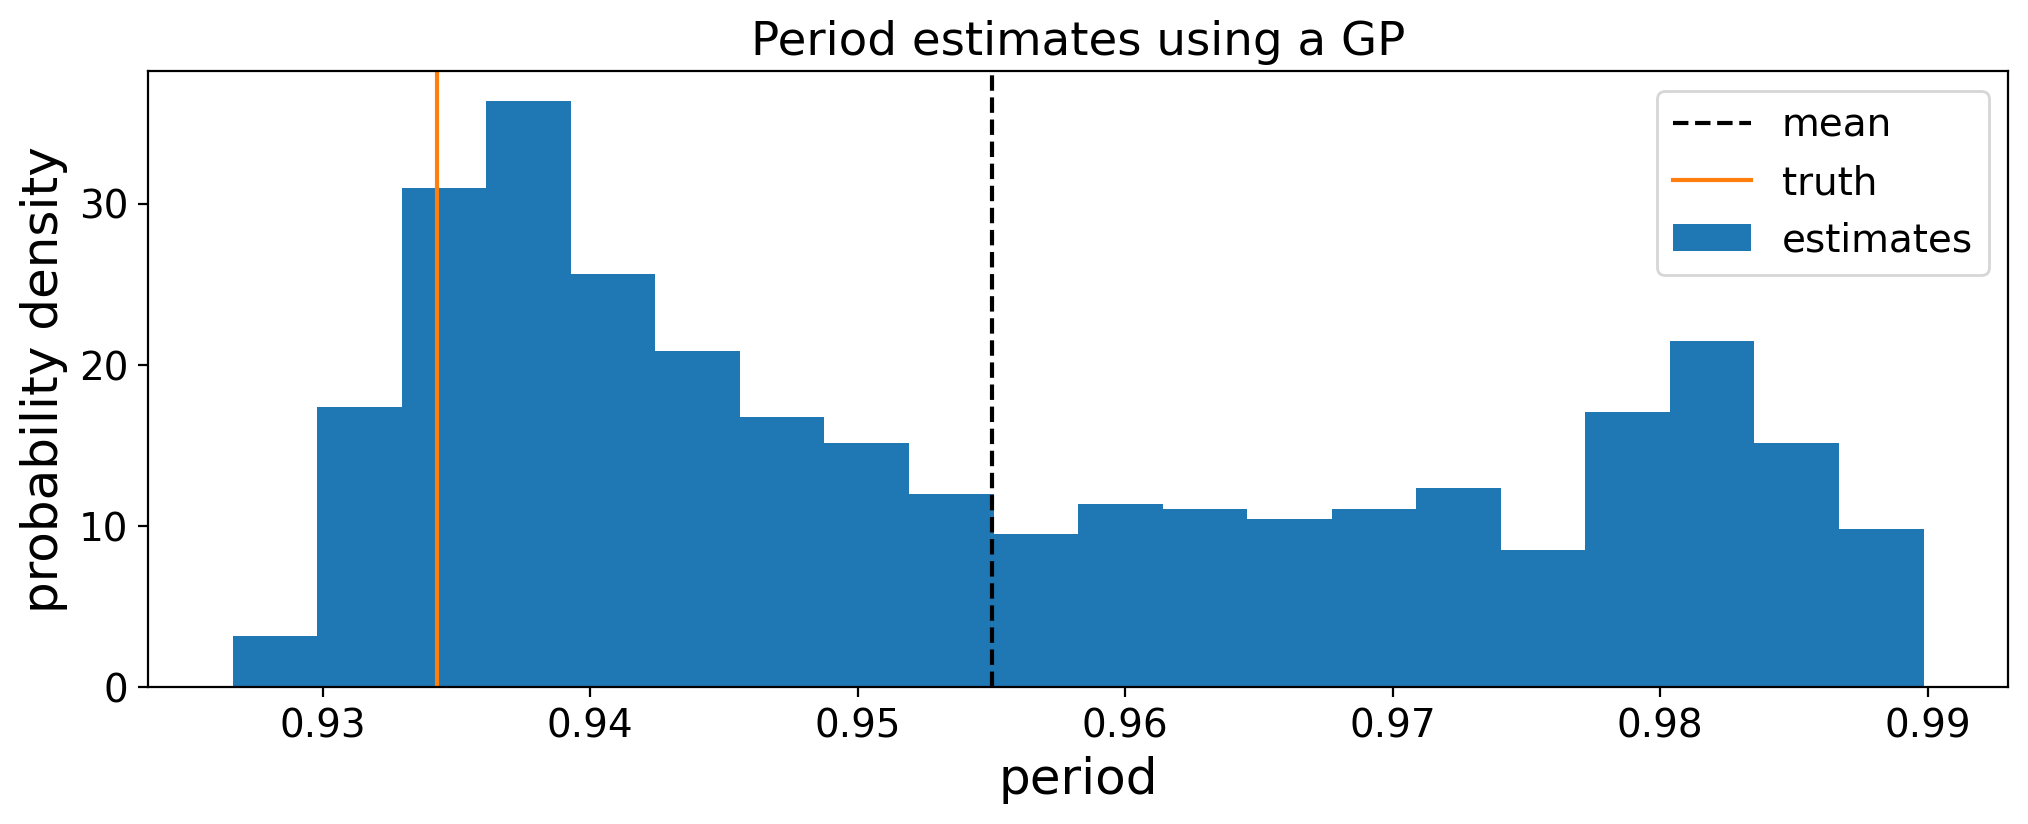

In [20]:
plt.hist(p_mean_george_norm, bins=20, density=True, label="estimates")
plt.axvline(np.mean(p_mean_george_norm), color="k", ls="--", label="mean");
plt.axvline(p_true, color="C1", label="truth")
plt.legend()
plt.xlabel("period", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period estimates using a GP");

It looks **very** wrong! As before, the orange line is the true value, and the dashed black line is the mean of the blue distribution. While the *mode* of our distribution of max-like periods is close to the true value, the distribution has a very heavy tail toward large periods and is thus significantly biased *high*.

Let's look at the distribution of residuals:

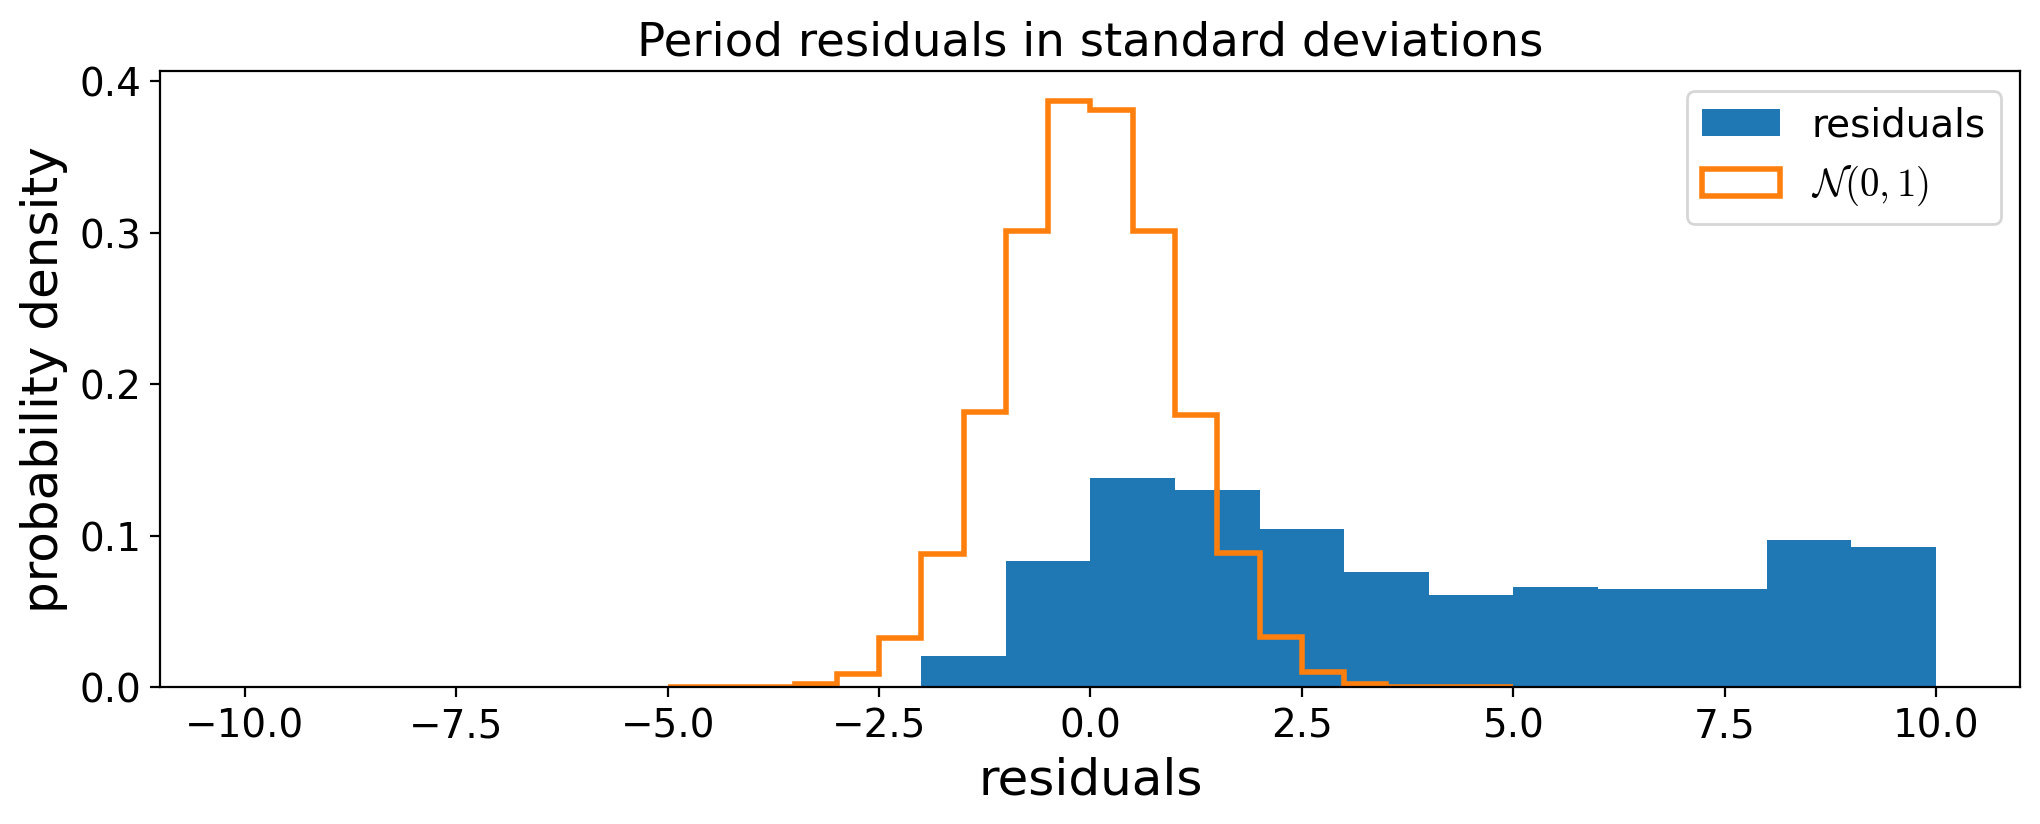

In [21]:
resid = (p_mean_george_norm - p_true) / p_std_george_norm
plt.hist(resid, bins=20, density=True, range=(-10, 10), label="residuals")
plt.hist(
    norm.rvs(size=100000),
    bins=20,
    density=True,
    histtype="step",
    lw=2,
    range=(-5, 5),
    label=r"$\mathcal{N}(0, 1)$"
)
plt.legend()
plt.xlabel("residuals", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period residuals in standard deviations");

The distribution is asymmetric about the truth (which we knew already from the previous plot). Not only that, but we're also *underestimating* the variance: there are far more estimates $>3\sigma$ away from the true value than there should be!

This is because...

<style>
.isa_warning {
    margin: 10px 0px;
    padding: 12px;
 
}
.isa_warning {
    color: #9F6000;
    background-color: #FEEFB3;
    font-size:1.25em;
    border-radius: 2px;
}
</style>

<div class="isa_warning">
    The period of a periodic GP is a <span style="font-weight:600">biased</span> estimate of the period of a sinusoid when the dataset is <span style="font-weight:600">normalized</span> and the baseline is <span style="font-weight:600">fixed</span>.
</div>

Fortunately, as we will see below, there is a very simple way of fixing this: **just fit for an unknown baseline term.** But before we do that, let's dig into what's actually happening here.

*Note: In principle, the max like period and the period posterior mean could differ; for example, if the posterior is asymmetric. If you check out the* [notebook version](notebooks/NormalizedGP.ipynb) *of this blog post, we show that our approximation is valid and the max like period is always extremely close to the posterior mean, so that's not what's responsible for the bias here.*

In [22]:
# Bonus content
# -------------
#
# It's possible in principle that the posterior mean is significantly different
# from the maximum likelihood value; i.e., if the distribution is significantly
# skewed. What if this is causing the apparent bias?
# In this cell, we explicitly compute the likelihood on a 2D grid in log amplitude
# and log period and show that the max like period value is very close to the true
# posterior mean (implicitly assuming a uniform prior on those quantities).
# Specifically, we will show that the difference between the max like value and
# the true mean is much less than one posterior standard deviation.


def nll(x, data):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    ll = gp.log_likelihood(data, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


def get_maxlike_error(m=0):
    # Run the optimization
    guess = [np.log(amp_true ** 2 / 2), np.log(p_true)]
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(ynorm[m],))
    x0, x1 = results.x

    # Create a 2D grid centered at the max like value
    x0s = np.linspace(x0 - 6, x0 + 6, 100)
    x1s = np.linspace(x1 - 0.025, x1 + 0.025, 100)

    # Compute the log likelihood on the grid
    ll = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            ll[i, j] = -nll([x0s[i], x1s[j]], ynorm[m])

    # Get the likelihood and marginalize over the
    # amplitude by discretely summing over the first axis
    P = np.sum(np.exp(ll - np.max(ll)), axis=0)

    # Normalize it so that the probability integrates to 1
    P /= np.trapz(P, x1s)

    # Compute the *true* posterior mean and standard deviation
    posterior_mean = np.trapz(x1s * P, x1s)
    posterior_uncert = np.sqrt(np.trapz(x1s ** 2 * P, x1s) - posterior_mean ** 2)

    # Return the error on the posterior mean in units of the std. dev.
    return (x1 - posterior_mean) / posterior_uncert

# Uncomment me!
if False:

    # Compute the errors for the first 100 datasets
    # (we could do it for all of them, but this takes a LONG time!)
    errors = np.zeros(100)
    for m in tqdm(range(100)):
        errors[m] = get_maxlike_error(m)

    # Print the maximum error
    # As expected, the difference between the
    # max like period and the posterior mean is very tiny!
    print(
        "The maximum difference between max like and posterior mean is {:.3f} standard deviations.".format(
            np.max(np.abs(errors))
        )
    )

## What's going on?

The results above might seem very counterintuitive. How can normalizing a dataset $-$ a simple rescaling of the $y$ axis $-$ lead to a change in the apparent *period* of the data? The answer is that technically, it's not changing the period: it's changing the entire covariance structure of the dataset, which invalidates some of the assumptions we make when we model the data with a GP (or, as we will see, other common approaches as well).

To see this, let's compute the empirical covariance of all our unnormalized datasets, $\pmb{\Sigma}$, and the empirical covariance of all our normalized datasets, which we will call $\tilde{\pmb{\Sigma}}$ (computing these is just a matter of calling of ``np.cov``). Below we visualize these matrices, alongside the difference between them:

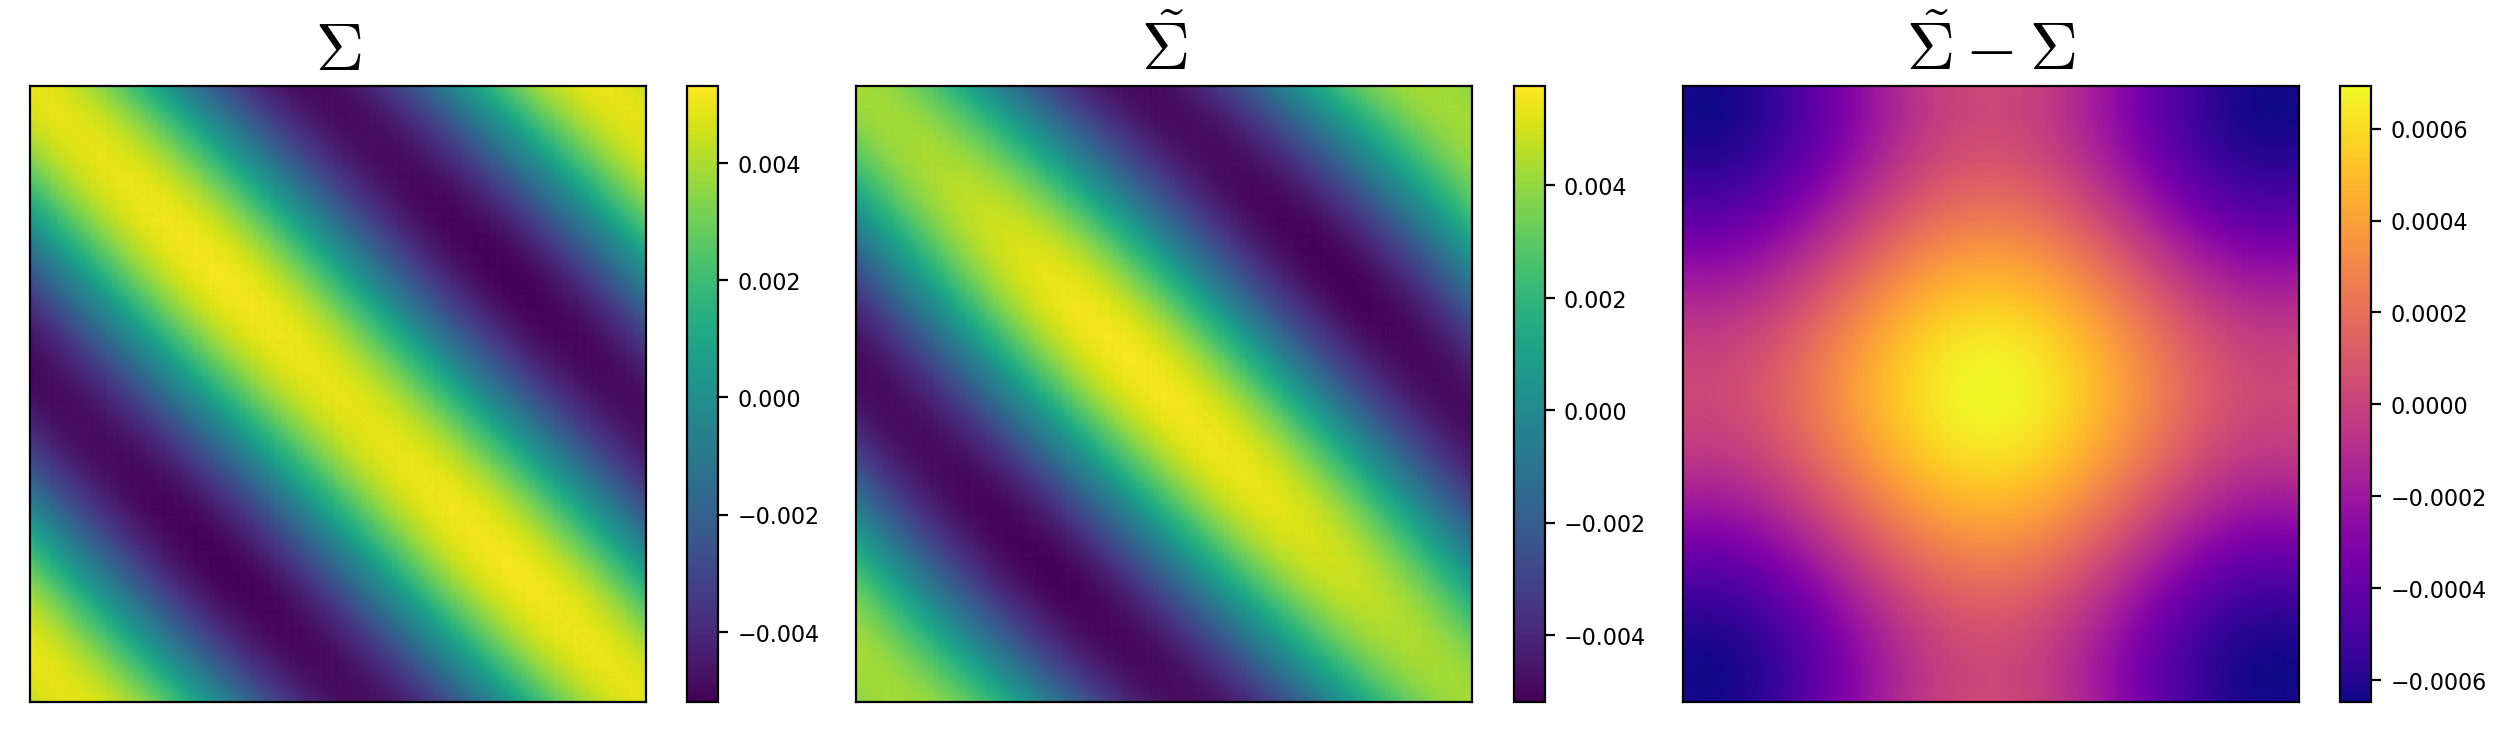

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(wspace=0)
im = ax[0].imshow(np.cov(y.T))
cb = plt.colorbar(im, ax=ax[0])
cb.ax.tick_params(labelsize=8) 
ax[0].set_title(r"$\Sigma$", fontsize=24)
im = ax[1].imshow(np.cov(ynorm.T))
cb = plt.colorbar(im, ax=ax[1])
cb.ax.tick_params(labelsize=8)
ax[1].set_title(r"$\tilde{\Sigma}$", fontsize=24)
im = ax[2].imshow((np.cov(ynorm.T) - np.cov(y.T)), cmap="plasma")
cb = plt.colorbar(im, ax=ax[2])
cb.ax.tick_params(labelsize=8) 
ax[2].set_title(r"$\tilde{\Sigma} - \Sigma$", fontsize=24)
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

The periodic structure of the data is apparent in both $\pmb{\Sigma}$ and $\tilde{\pmb{\Sigma}}$: data points close to each other are positively correlated (bright), while data points half a cycle away are negatively correlated (dark). And data points on opposite ends of the light curve are positively correlated, since they are close to one cycle apart.

There is, however, one subtle difference between the two matrices: the covariance of the normalized data, $\tilde{\pmb{\Sigma}}$, has some extra structure beyond the diagonal bands. It's much easier to see this structure in the difference (right panel). This panel suggests that data points close to the center of the light curve have larger variance (brighter colors) than data points close to the edges (darker colors), *even though we generated the data from a homoscedastic (same uncertainty everywhere) process*. The process describing the normalized data is non-stationary!

What?

To understand this, let's take a step back and consider the same problem but in the limit that we observe only a very small fraction of a sinusoidal cycle. If we generate a bunch of (unnormalized, un-noised) datasets from this process, they would look something like this:

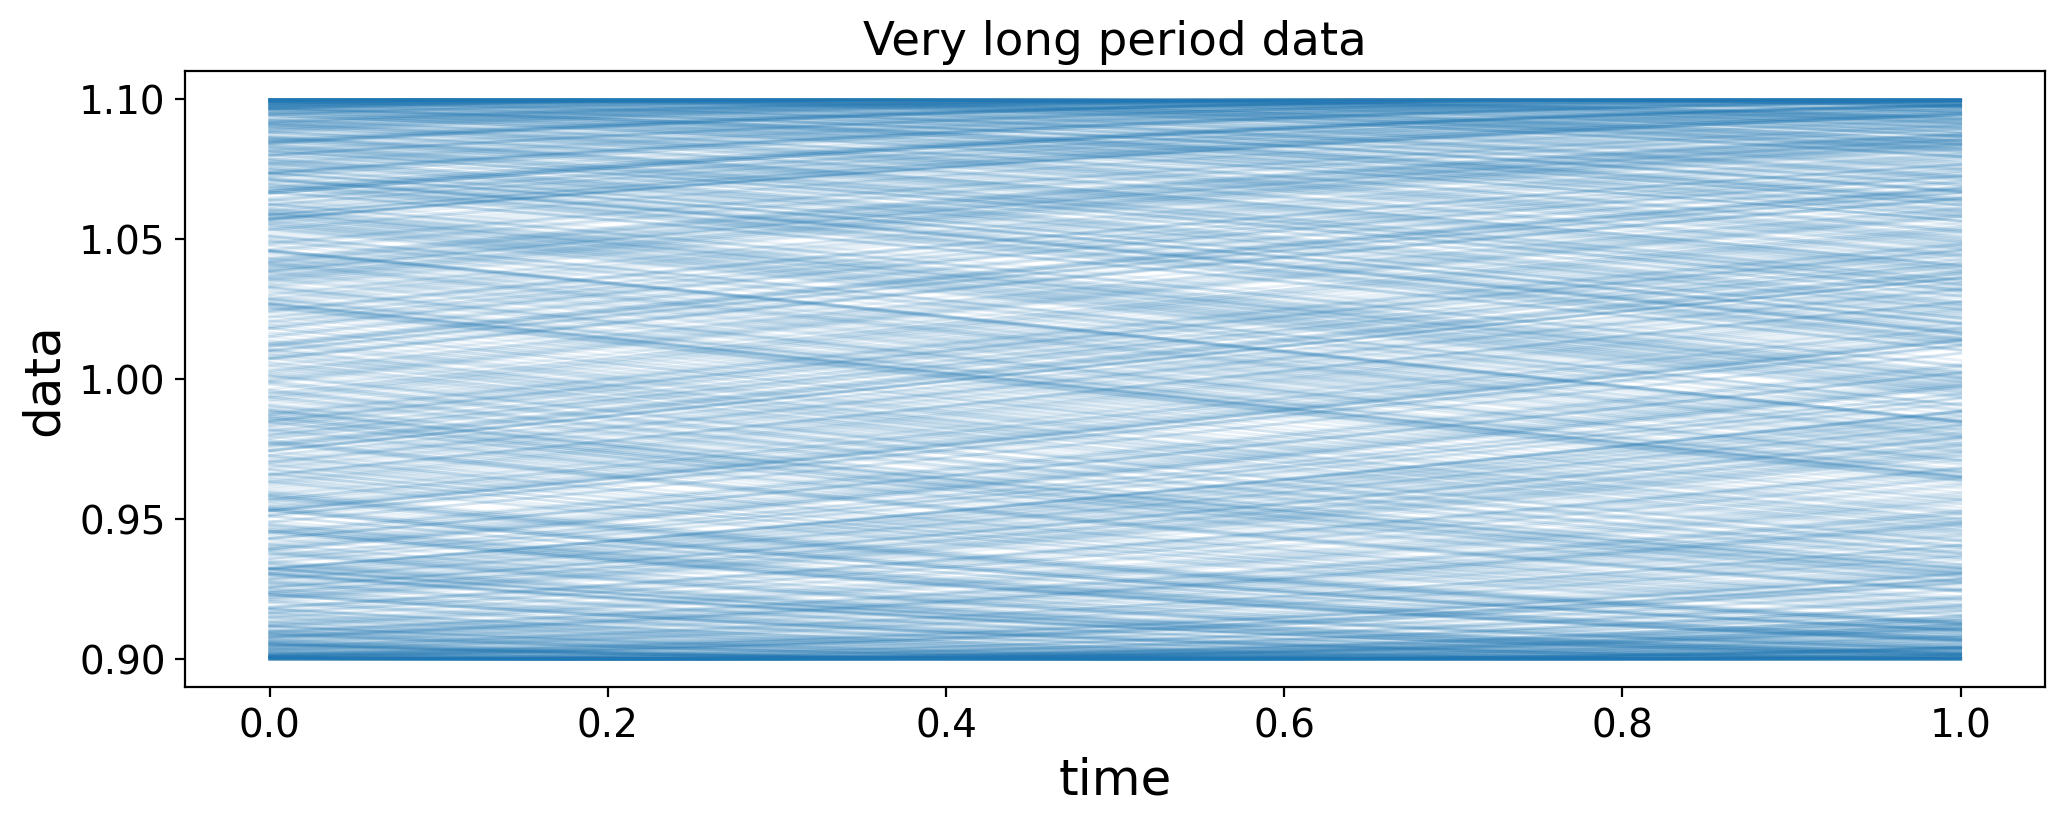

In [24]:
np.random.seed(0)
z = 1 + 0.1 * np.sin(
    2 * np.pi / 10 * t.reshape(1, -1) + 2 * np.pi * np.random.random(size=(1000, 1))
)
for k in range(len(z)):
    plt.plot(t, z[k], color="C0", lw=1, alpha=0.1)
plt.xlabel("time", fontsize=18)
plt.ylabel("data", fontsize=18)
plt.title("Very long period data");

The plot shows 1000 datasets generated from a sinusoid with amplitude 0.1, unit mean, and period 10 times longer than the observation window. Since the period is so long, individual datasets look pretty linear: just a trend that's either up, down, or relatively flat.

Now let's normalize each of these to their mean value and plot the normalized datasets:

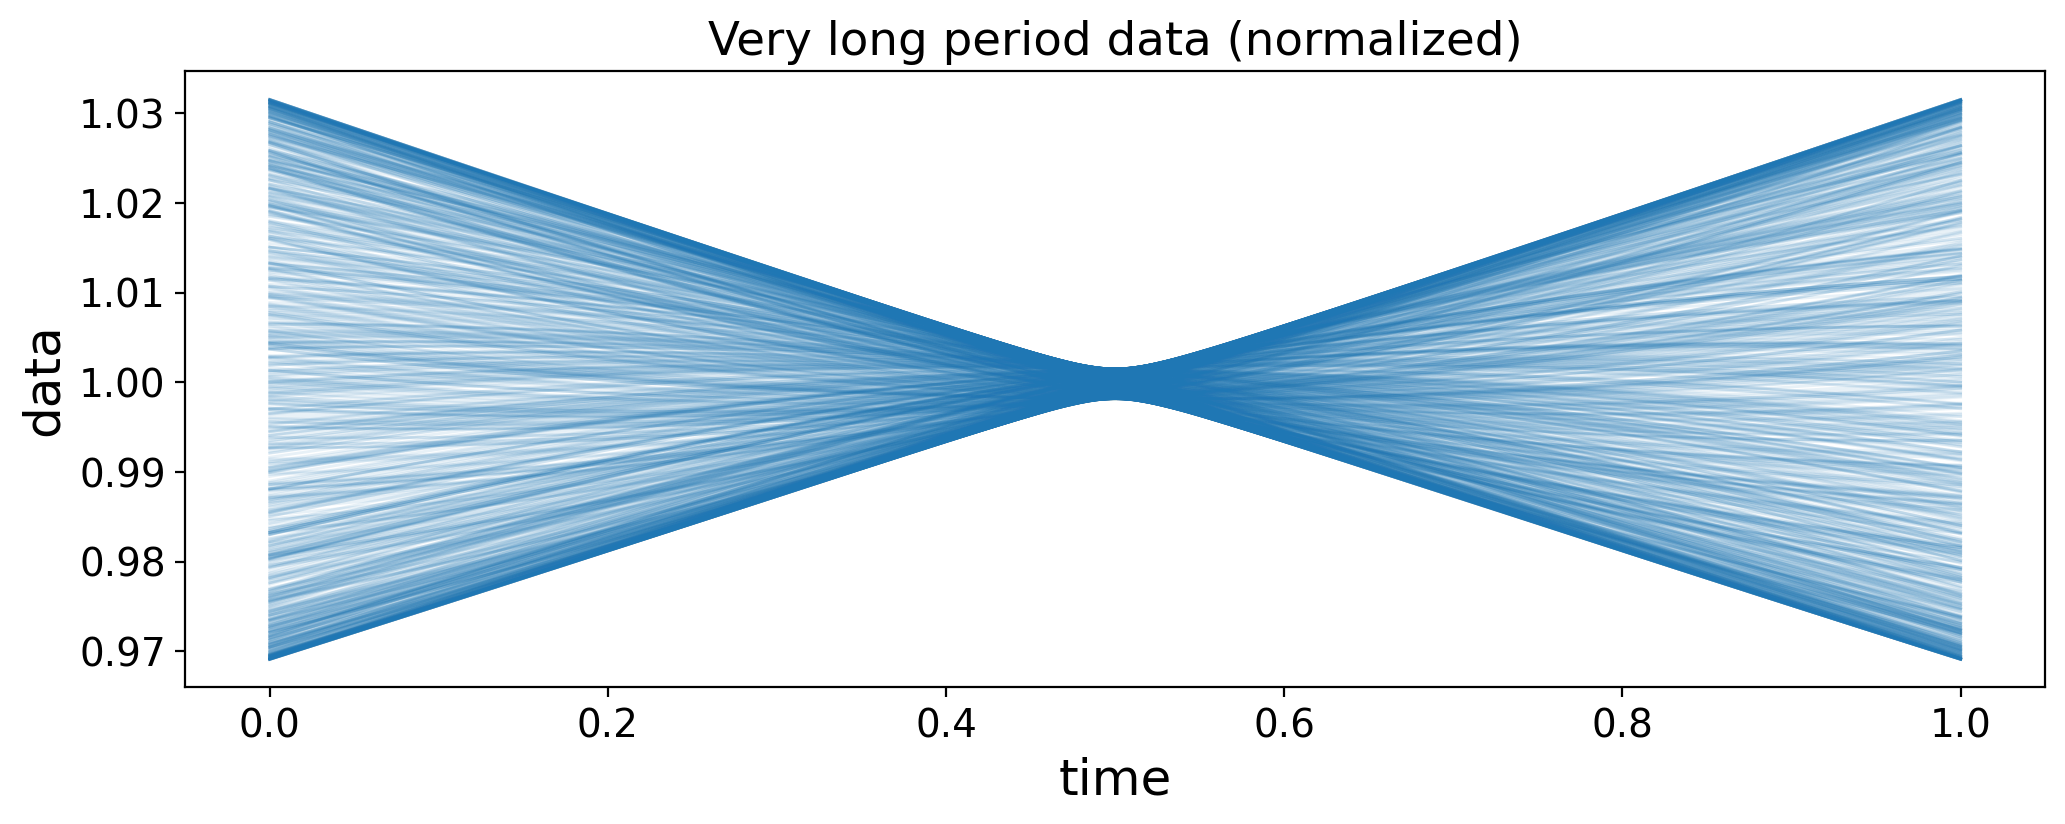

In [25]:
znorm = z / np.mean(z, axis=1).reshape(-1, 1)
for k in range(len(z)):
    plt.plot(t, znorm[k], color="C0", lw=1, alpha=0.1)
plt.xlabel("time", fontsize=18)
plt.ylabel("data", fontsize=18)
plt.title("Very long period data (normalized)");

Something very interesting happened! The data all appear to "pinch" at the center and flare out at the edges. Speaking in terms of variances, the data is now distinctly heteroscedastic: the variance is large at the edges and tiny at the center. That's exactly what we found when we visualized the covariance matrices above.

But it's easier to understand why this is happening here. The mean of a linear trend is *always* exactly at the center. So when we divide a linear trend by its mean, we are implicitly dividing it by whatever value it has at the middle (in this case, at $t=0.5$). The value of the normalized process at $t = 0.5$ will therefore be *exactly unity for all realizations of the process*, leading to vanishing variance at that point. At the edges, the function is the most different from the mean value, so under normalization it will experience the largest changes, leading to higher variance there.

The argument above applies when the trend is *exactly* linear. The data in the figure have a bit of curvature (since it's really a long period sinusoid), so in practice the variance is nonzero, but still small, at the center. As we observe a larger fraction of a full cycle, this effect decreases, but doesn't go away. Our main example in this post is an observation of slightly *more* than one cycle, and the bias is still operating!

Anyways, back to the main point. We've seen that normalization changes the covariance structure of the data, but why does that affect our measurement of the period?

To understand this, let's plot the first column of the covariance matrix for the original data and the normalized data. These tell us how points in the dataset correlate with the first point of the dataset. To exaggerate the effect, let's consider the case in which we observe $2/3$ of a dataset (i.e., the period is $1.5$ days but we observe for only $1$ day).

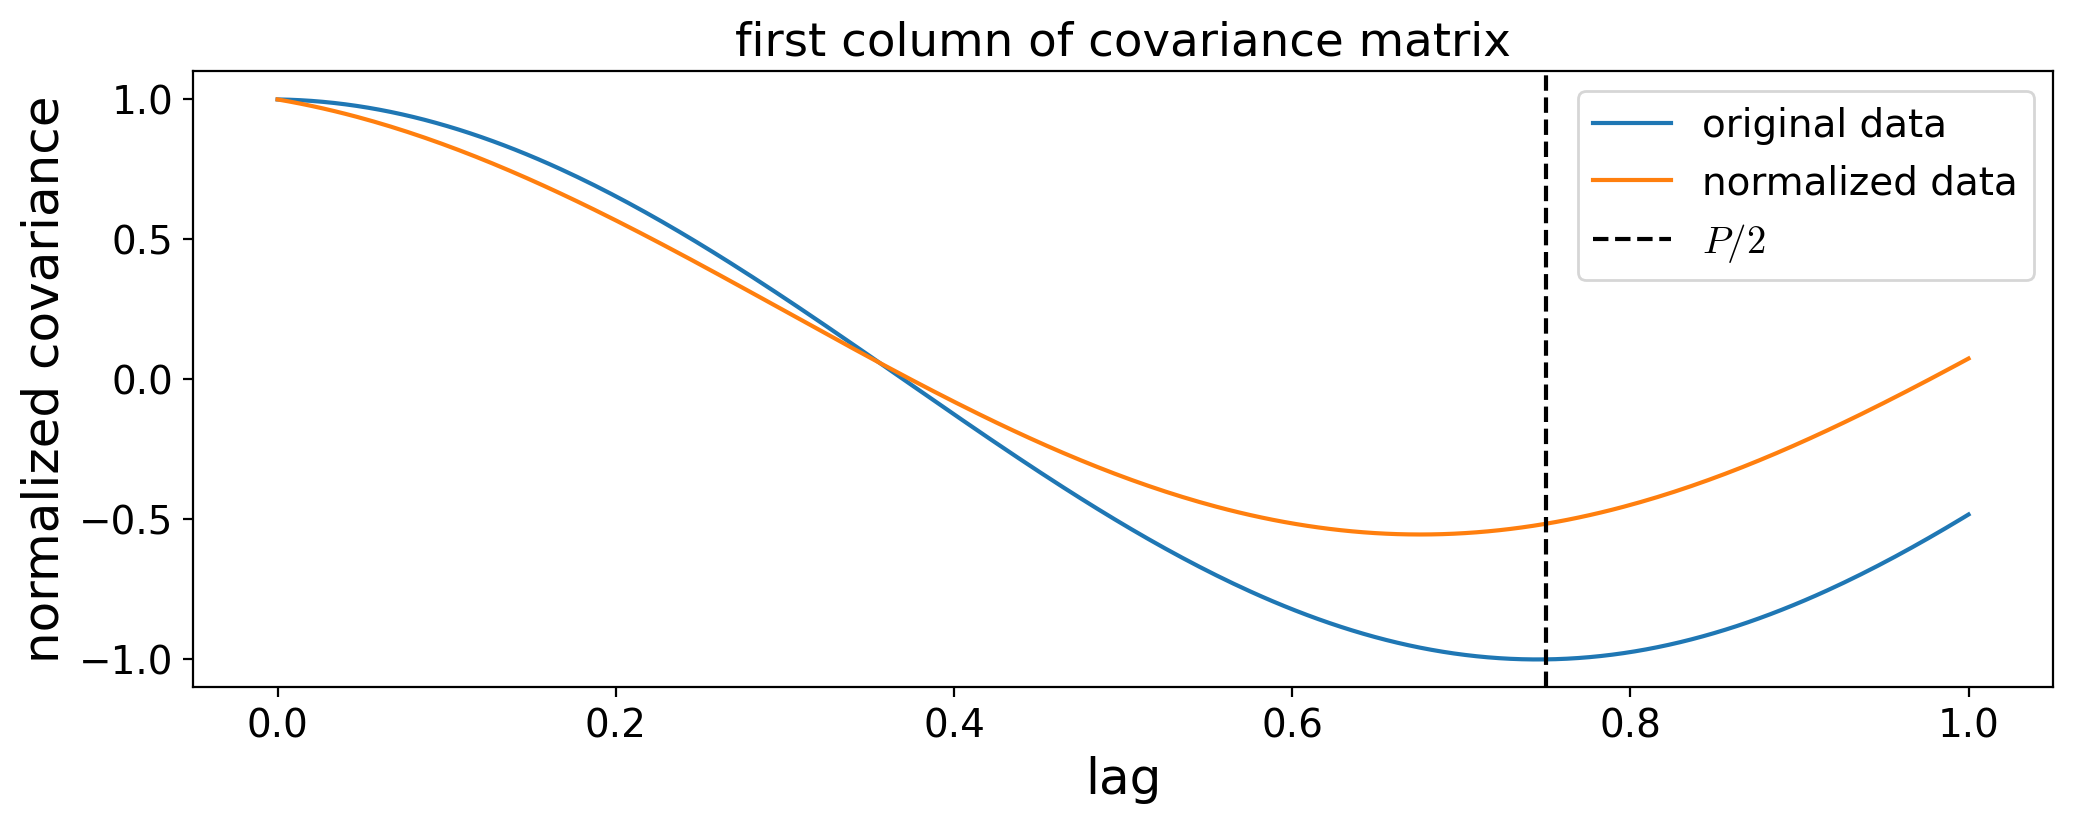

In [26]:
np.random.seed(0)
z = 1 + 0.1 * np.sin(
    2 * np.pi / 1.5 * t.reshape(1, -1) + 2 * np.pi * np.random.random(size=(1000, 1))
)
znorm = z / np.mean(z, axis=1).reshape(-1, 1)
Cz = np.cov(z.T)
Cznorm = np.cov(znorm.T)
plt.plot(t, Cz[0] / Cz[0, 0], label="original data")
plt.plot(t, Cznorm[0] / Cznorm[0, 0], label="normalized data");
plt.axvline(0.75, ls="--", color="k", label="$P / 2$")
plt.ylabel("normalized covariance", fontsize=18)
plt.xlabel("lag", fontsize=18)
plt.legend()
plt.title("first column of covariance matrix");

Let's look at the blue curve first, corresponding to the covariance of the original (unnormalized) data. The thing to note is that its minimum is at exactly half the period: since the process is perfectly periodic, points this far apart are exactly anti-correlated. But when we look at the orange curve, corresponding to the covariance of the normalized data, we notice that its minimum occurs at a significantly smaller lag, suggesting a shorter period!

That's because the non-stationary component of the covariance (the difference image $\tilde{\Sigma} - \Sigma$ a few plots ago) effectively changes the periodicity of the data at different lags. If we were to plot different columns of the covariance, we would see that the minimum of the normalized covariance would shift relative to that of the original data.

So when we use a stationary Gaussian process to model periodic, *non-stationary* data, we're bound to get some bias!

Fortunately, in practice we can get rid of this bias by simpling fitting for a baseline term. Let's take a look at that in the next section.

## Inference using a cosine kernel and fitting for the baseline

We're going to do the same exact thing here, but this time we will fit for the mean of the normalized dataset, *even though the mean is known to be unity by construction.* This is **always** a good idea, and as we'll see, a *crucial* thing to do in this case. We're therefore fitting for three parameters (mean, amplitude, and period), even though we only care about one (the period).

In [27]:
p_mean_george_norm_bl = np.empty(ndatasets)
p_std_george_norm_bl = np.empty(ndatasets)


def nll(x, data):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    ll = gp.log_likelihood(data, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(x, data):
    """Return the gradient of the negative log likelihood of ``data`` conditioned on params ``x``."""
    gp.set_parameter_vector(x)
    return -gp.grad_log_likelihood(data, quiet=True)


# Initial guesses (log amp^2, log period)
guess = [1.0, np.log(amp_true ** 2 / 2), np.log(p_true)]


# Run the optimizer on each dataset
for m in tqdm(range(ndatasets)):

    # Set up the periodic GP
    gp = george.GP(
        np.exp(guess[0]) * CosineKernel(guess[1]), white_noise=np.log(sigmanorm[m] ** 2), mean=1.0, fit_mean=True
    )
    gp.compute(t)
    
    # Find the period at max likelihood
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(ynorm[m],))
    _, _, p_mean_george_norm_bl[m] = np.exp(results.x)
    
    # Laplace approximation to get the local posterior std. dev.
    eps = 1e-8 * grad_nll(results.x, ynorm[m])[2]
    p_std_george_norm_bl[m] = np.sqrt(
        (2 * eps)
        / (
            grad_nll(results.x + np.array([0.0, 0.0, eps]), ynorm[m])[2]
            - grad_nll(results.x - np.array([0.0, 0.0, eps]), ynorm[m])[2]
        )
    )

Here's the distribution of period estimates when including a baseline term in the fit:

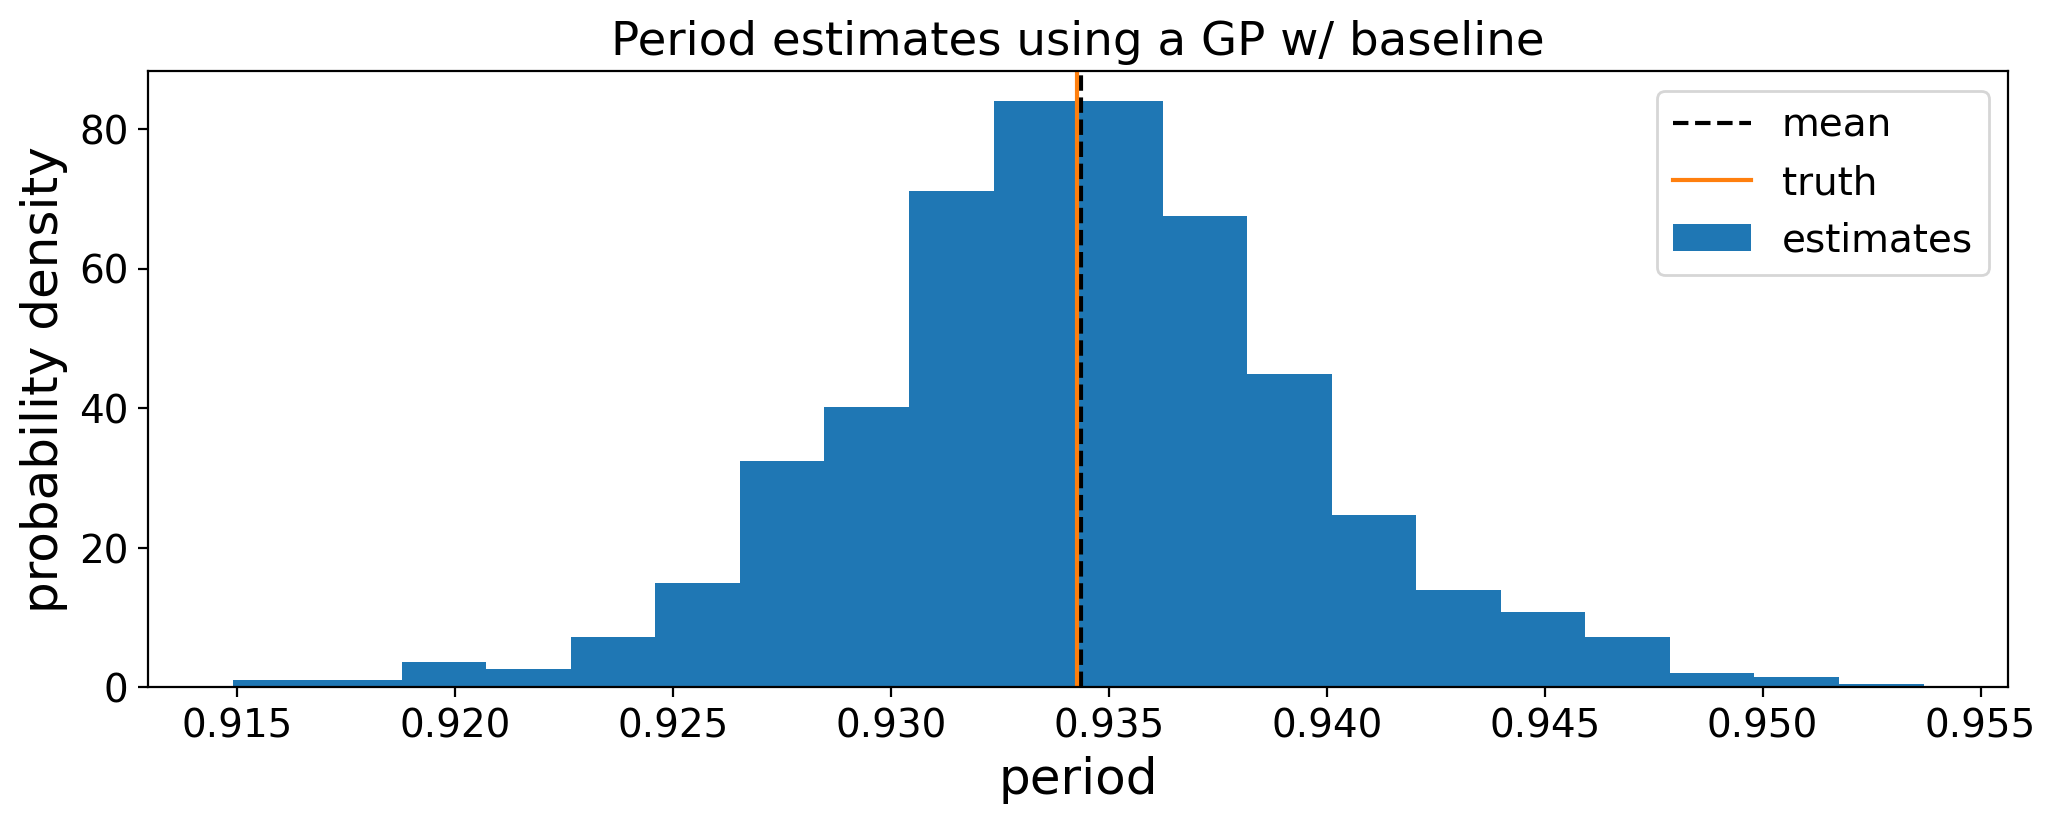

In [28]:
plt.hist(p_mean_george_norm_bl, bins=20, density=True, label="estimates")
plt.axvline(np.mean(p_mean_george_norm_bl), color="k", ls="--", label="mean");
plt.axvline(p_true, color="C1", label="truth")
plt.legend()
plt.xlabel("period", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period estimates using a GP w/ baseline");

And here's the corresponding distribution of residuals:

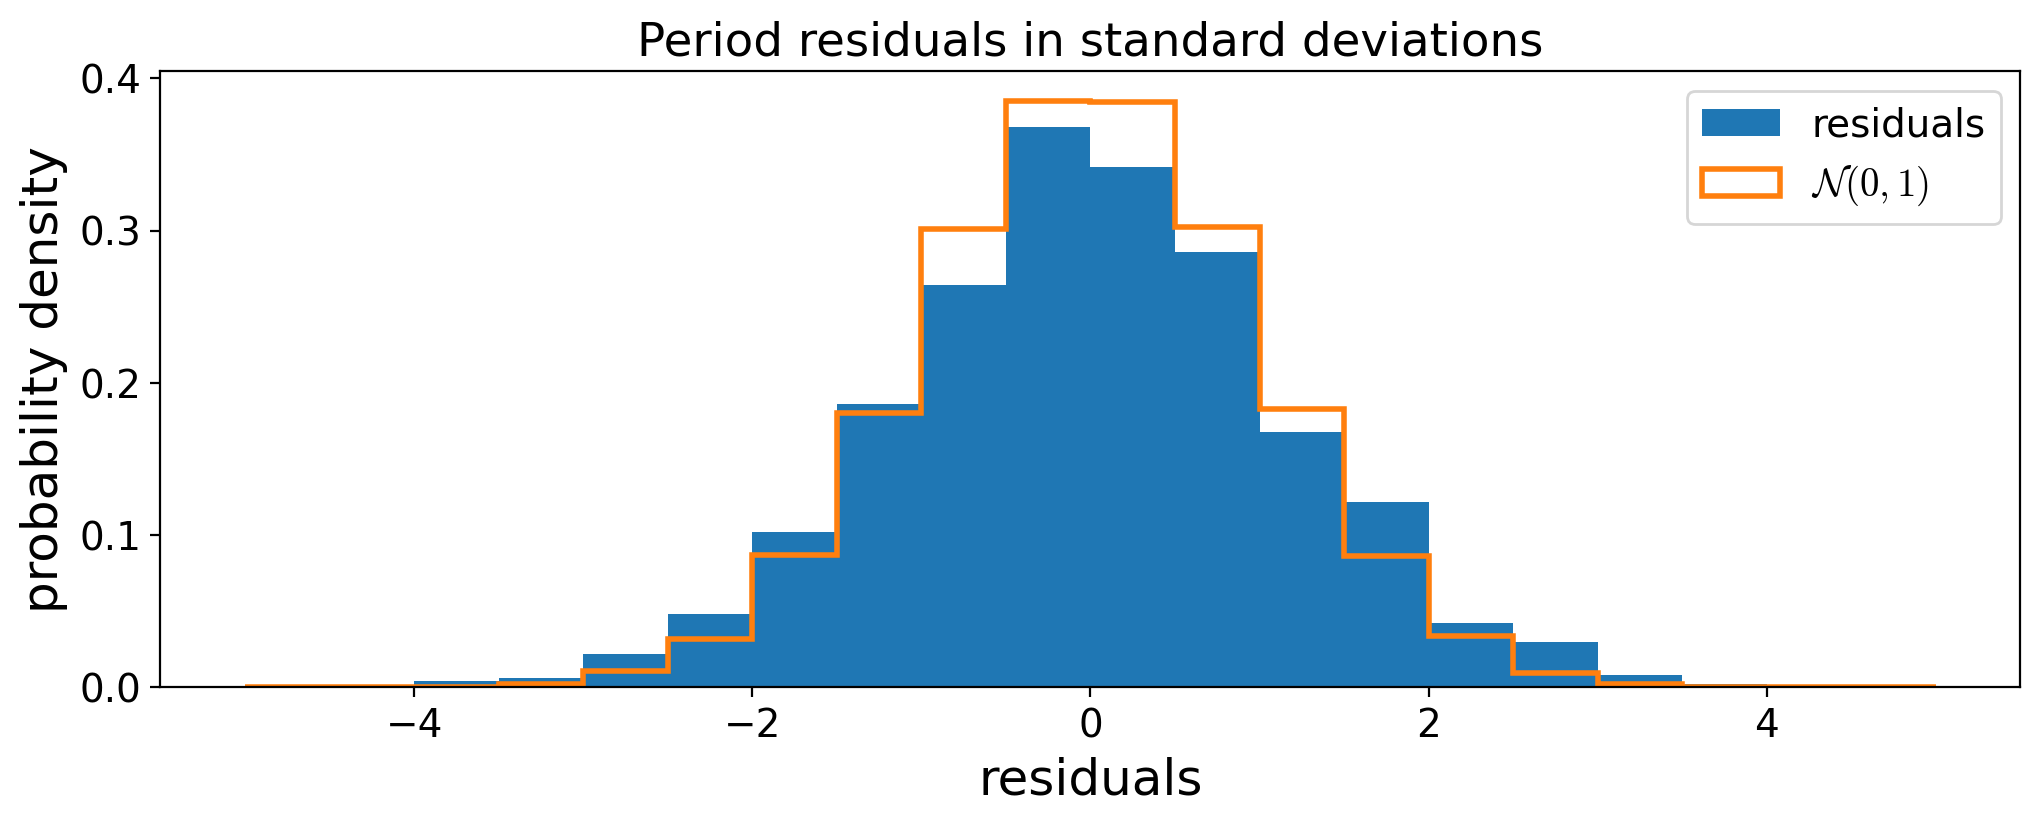

In [29]:
resid = (p_mean_george_norm_bl - p_true) / p_std_george_norm_bl
plt.hist(resid, bins=20, density=True, range=(-5, 5), label="residuals")
plt.hist(
    norm.rvs(size=100000),
    bins=20,
    density=True,
    histtype="step",
    lw=2,
    range=(-5, 5),
    label=r"$\mathcal{N}(0, 1)$"
)
plt.legend()
plt.xlabel("residuals", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period residuals in standard deviations");

It looks great! We've effectively turned the GP back into an unbiased estimator for the period.

<style>
.isa_info {
    margin: 10px 0px;
    padding: 12px;
 
}
.isa_info {
    color: #00529B;
    background-color: #BDE5F8;
    font-size:1.25em;
    border-radius: 2px;
}
</style>

<div class="isa_info">
    The period of a periodic GP is an <span style="font-weight:600">unbiased</span> estimate of the period of a sinusoid when the dataset is <span style="font-weight:600">normalized</span> and the baseline is <span style="font-weight:600">allowed to vary</span>.
</div>

## Inference using a normalized Gaussian process

Fitting for the baseline term is usually all you need to do to correct for the normalization of the data. But note that it's still a bit of a hack, since we're using a *stationary* GP to fit an intrinsically *non-stationary* dataset.
Sometimes, we need to explicitly model this non-stationarity. This is what I ran into while developing my [interpretable GP for stellar light curves](https://luger.dev/starry-process-about.html), where the GP is not just a simple
``CosineKernel``, but a complicated function of spot properties. In that case, I don't want to *marginalize* over some unknown baseline to correct for the non-stationarity of the data: instead, I want to model the non-stationarity to squeeze as much information as I can out of the dataset.

In an upcoming paper, I show that we can construct the covariance matrix for the Gaussian process that best approximates the covariance of a normalized dataset. The details are beyond the scope of this blog post (perhaps I'll cover them in the next one), so I'll just state the result here. As before, let's call the covariance of the normalized process $\tilde{\mathbf{\Sigma}}$. In my paper, I show that it's a straightforward function of the original covariance $\mathbf{\Sigma}$, given by

$$
\tilde{\mathbf{\Sigma}} \approx
\frac{A}{\mu^2} \mathbf{\Sigma} +
z \Big(
(A + B) \, (\mathbf{1} - \mathbf{q}) \, (\mathbf{1} - \mathbf{q})^\top
- A \, \mathbf{q} \, \mathbf{q}^\top
\Big)
$$

where

$$
z \equiv \frac{\left< \Sigma \right>}{\mu^2}
$$

is a dimensionless parameter equal to the ratio of the average element of the covariance to the square of the GP mean,

$$
\mathbf{q} \equiv  \left( 
\frac{\left< \mathbf{\Sigma_0} \right>}{\left< \Sigma \right>} 
\,\,\,
\frac{\left< \mathbf{\Sigma_1} \right>}{\left< \Sigma \right>} 
\,\,\,
\cdots 
\,\,\,
\frac{\left< \mathbf{\Sigma_{N-1}} \right>}{\left< \Sigma \right>} \right)^\top
$$

is the ratio of the average of each row in $\pmb{\Sigma}$ to the average element in $\pmb{\Sigma}$,
and

$$
    A \equiv
    \sum\limits_{i=0}^{i_\mathrm{max}}
    \frac{(2i + 1)!}{2^i \, i!}
    z^i
$$

$$
    B \equiv
    \sum\limits_{i=0}^{i_\mathrm{max}}
    \frac{2i(2i + 1)!}{2^i \, i!}
    z^i
$$

are constants of order unity and zero, respectively. Their computation is a bit tricky, because the sums defining them **do not converge** when taken to infinity. I'll (hopefully) go into this in more detail in the next blog post, but the basic idea is that it's simply *wrong* to normalize a Gaussian process! When we model something as a GP, the implicit assumption is that the process used to generate the data is a GP. In practice this isn't true, but it's a useful assumption that lets us compute likelihoods and do fast inference, and it works great in general. Anyways, that's all fine; the issue is when we try to normalize the data generated by a GP. Most of the time, it works great: just compute the mean of your vector of measurements and divide by it. But because GPs are just Gaussians, and Gaussians have infinite support, there is a chance (however small) that the mean of some realization of the GP gets very close to zero. And when the mean is arbitrarily close to zero, the normalized dataset blows up (since we're dividing by the mean). While this might never happen in practice, especially when the GP mean is far from zero, if we sit down to derive the covariance of the normalized process, we find that it is *formally infinite*. That's because the normalized process has infinitely wide tails of very low probability, and therefore has no finite moments.

While that may seem like a dead end, we can wave our hands slightly and accept that if the GP mean is far from zero and the variance is small, we are unlikely to ever draw a GP (vector) sample whose mean is close to zero. In that case, we can approximate the covariance of the process as the sample covariance in the limit as the number of samples $N$ gets very large *but not infinite* (since that would lead to infinities). In practice, this works extremely well, and the result is equivalent to what we get with the expressions above, provided we truncate the series at some finite value $i = i_\mathrm{max}$. To determine $i_\mathrm{max}$, we note that as we increase $i$, the coefficients of the series in the expressions for $A$ and $B$ initially decrease in magnitude (provided $z$ is small), such that $A$ and $B$ appear to converge to specific, finite values. Eventually, however, the factorials in the numerator win out and the coefficients start increasing again (and go on to diverge). The best possible approximation for $i_\mathrm{max}$ is the value of $i$ at which this turning point occurs, which we can find by differentiating the expressions and finding their inflection points.

(If you're interested in this, check out the Wikipedia page on [Asymptotic expansion](https://en.wikipedia.org/wiki/Asymptotic_expansion). There's a whole class of functions whose series expansions are divergent, but can be approximated by this kind of truncation.)

Anyways, let's use the above expression for the normalized covariance matrix in our GP likelihood calculation, noting that the mean of the normalized GP is unity by definition (and we do not have to solve for it). Since the normalized covariance isn't computable in terms of traditional kernels (it's not even stationary!) we'll have to implement our own GP solver.

In [30]:
# Compile the likelihood function and its gradient
x_ = tt.dvector()
y_ = tt.dvector()
sigma_ = tt.dscalar()
get_ll = theano.function([x_, y_, sigma_], normgp.log_likelihood(x_, t, y_, mean=mean, sigma=sigma_, normalized=True))
get_grad_ll = theano.function(
    [x_, y_, sigma_],
    tt.grad(normgp.log_likelihood(x_, t, y_, mean=mean, sigma=sigma_, normalized=True), x_)
)

In [31]:
p_mean_luger_norm = np.empty(ndatasets)
p_std_luger_norm = np.empty(ndatasets)


def nll(x, data, uncert):
    """Return the negative log likelihood of ``data`` conditioned on params ``x``."""
    ll = get_ll(x, data, uncert)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(x, data, uncert):
    """Return the gradient of the negative log likelihood of ``data`` conditioned on params ``x``."""
    return -get_grad_ll(x, data, uncert)


# Initial guesses
guess = [np.log(amp_true ** 2 / 2), np.log(p_true)]

# Run the optimizer on each dataset
for m in tqdm(range(ndatasets)):

    # Find the period at max likelihood
    results = op.minimize(nll, guess, jac=grad_nll, method="L-BFGS-B", args=(ynorm[m], sigmanorm[m]))
    _, p_mean_luger_norm[m] = np.exp(results.x)

    # Laplace approximation to get the local posterior std. dev.
    eps = 1e-8 * grad_nll(results.x, ynorm[m], sigmanorm[m])[1]
    p_std_luger_norm[m] = np.sqrt(
        (2 * eps)
        / (
            grad_nll(results.x + np.array([0.0, eps]), ynorm[m], sigmanorm[m])[1]
            - grad_nll(results.x - np.array([0.0, eps]), ynorm[m], sigmanorm[m])[1]
        )
    )

After running inference on the normalized dataset using our normalized GP, here is the distribution of max-like periods:

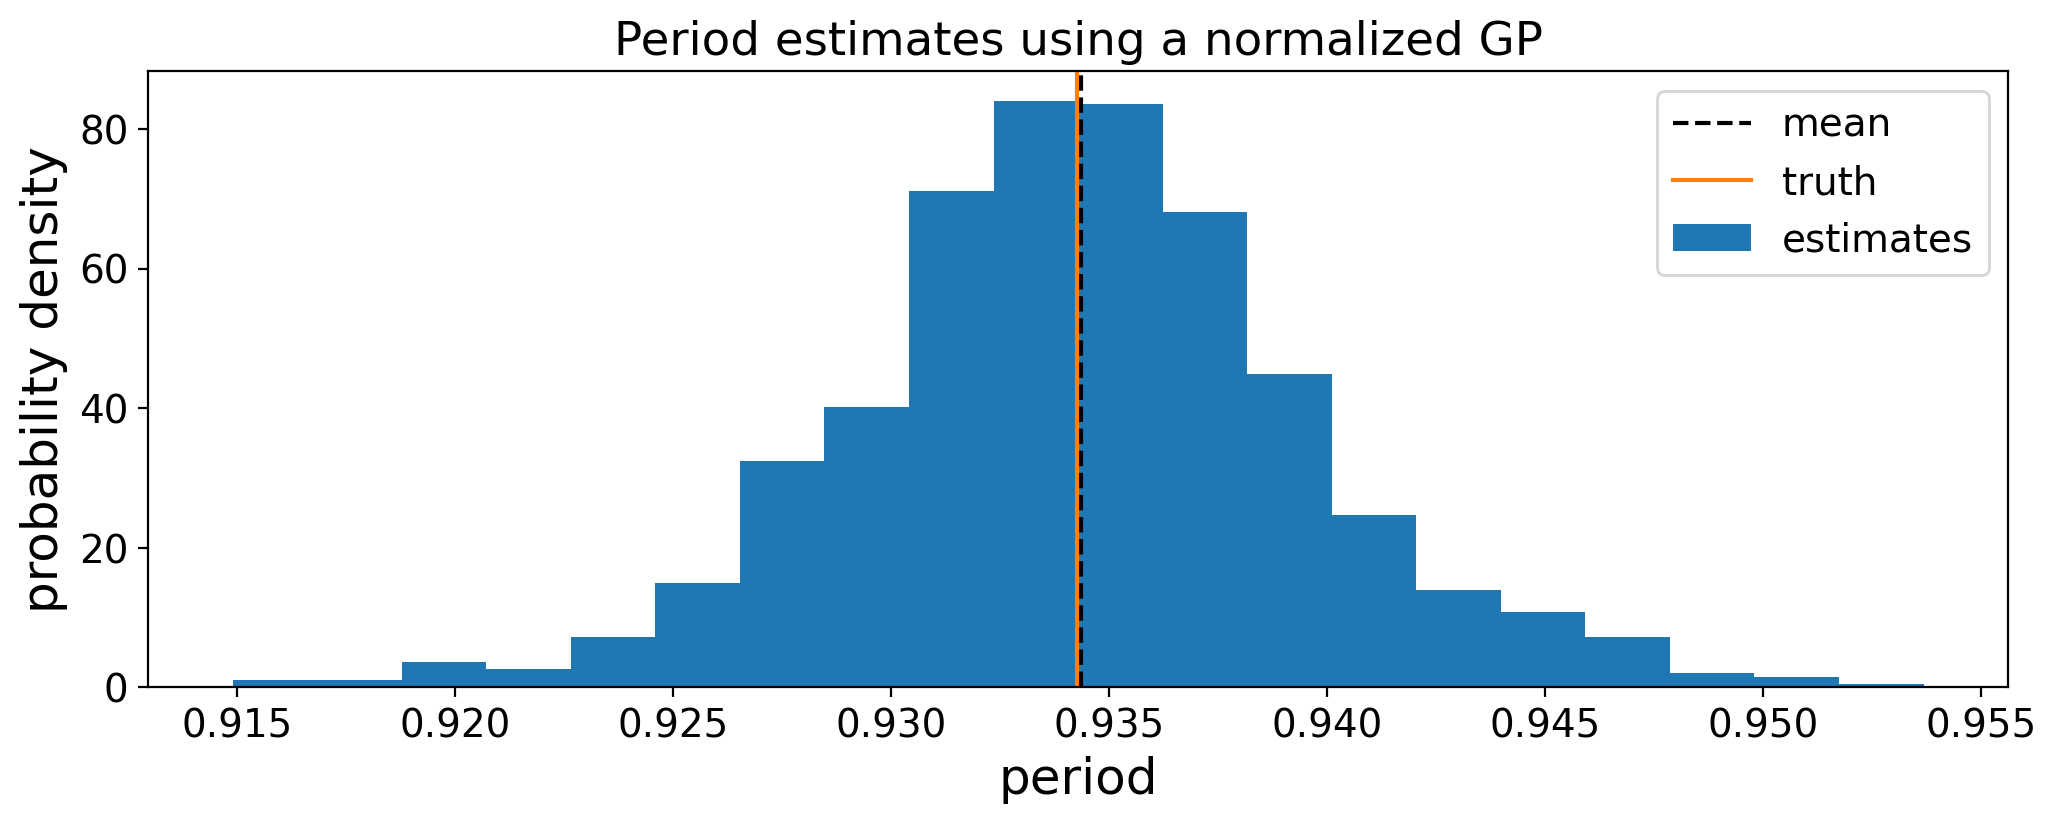

In [37]:
plt.hist(p_mean_luger_norm, bins=20, density=True, label="estimates")
plt.axvline(np.mean(p_mean_luger_norm), color="k", ls="--", label="mean");
plt.axvline(p_true, color="C1", label="truth")
plt.legend()
plt.xlabel("period", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period estimates using a normalized GP");

It's unbiased!

Let's look at the distribution of residuals:

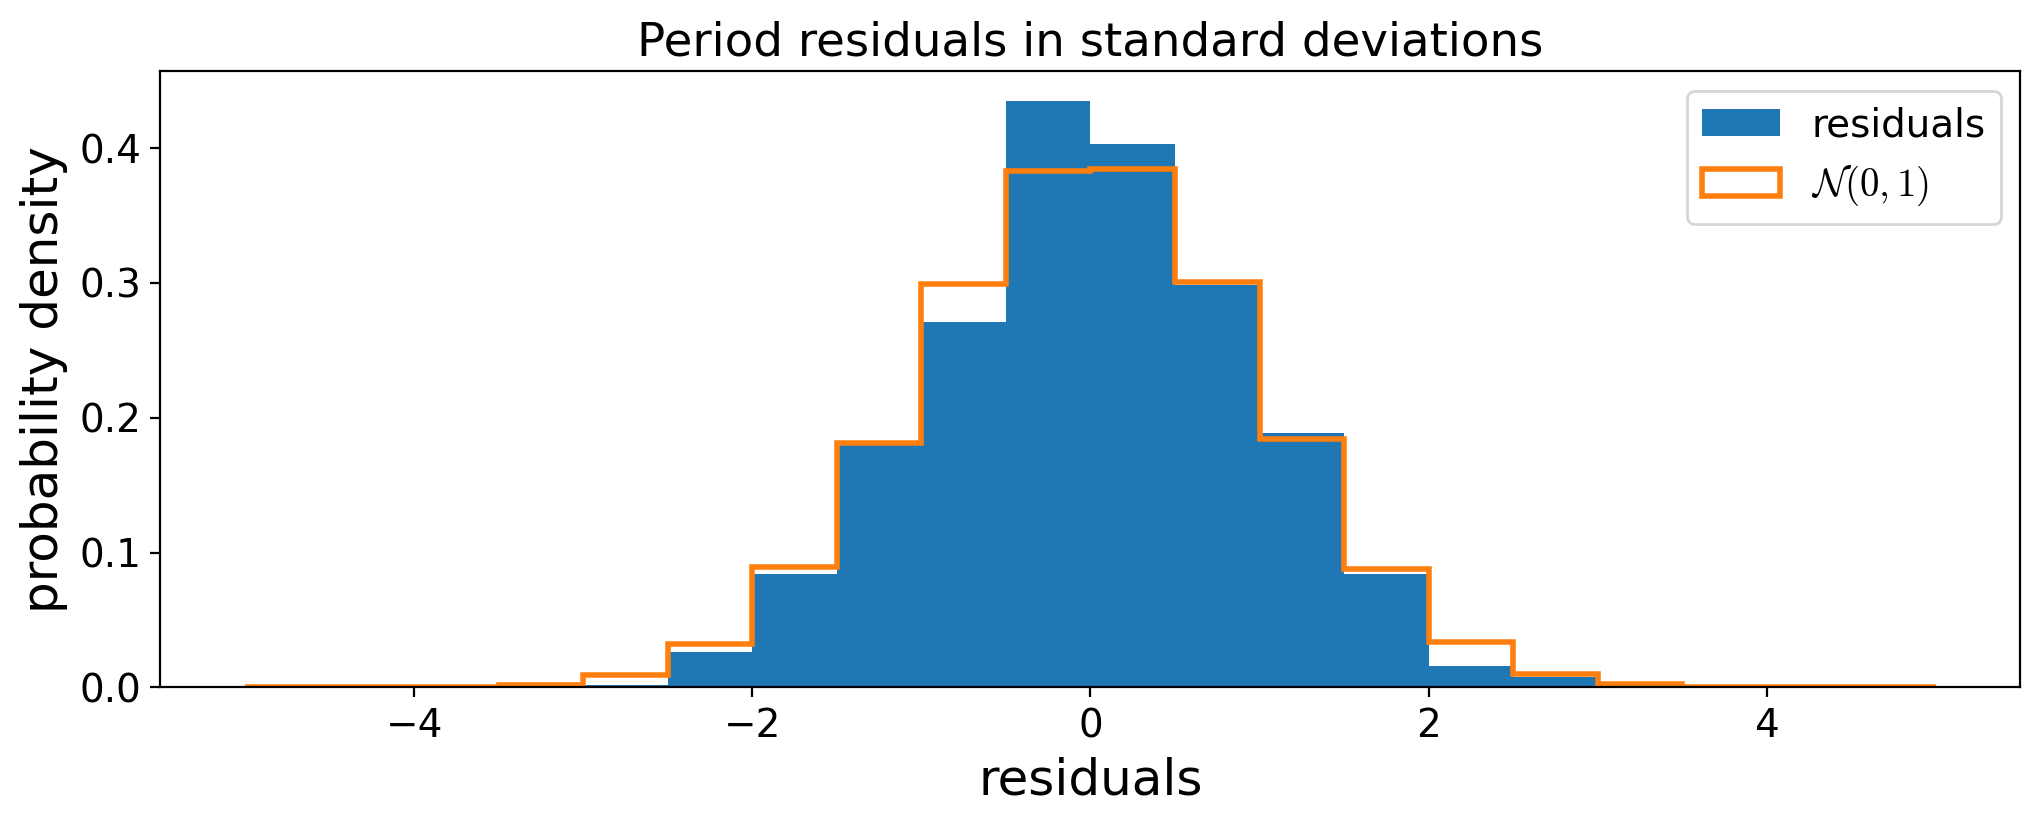

In [35]:
resid = (p_mean_luger_norm - p_true) / p_std_luger_norm
plt.hist(resid, bins=20, density=True, range=(-5, 5), label="residuals")
plt.hist(
    norm.rvs(size=100000),
    bins=20,
    density=True,
    histtype="step",
    lw=2,
    range=(-5, 5),
    label=r"$\mathcal{N}(0, 1)$"
)
plt.legend()
plt.xlabel("residuals", fontsize=18)
plt.ylabel("probability density", fontsize=18)
plt.title("Period residuals in standard deviations");

It's also well calibrated, since the variance is estimated correctly!

<style>
.isa_info {
    margin: 10px 0px;
    padding: 12px;
 
}
.isa_info {
    color: #00529B;
    background-color: #BDE5F8;
    font-size:1.25em;
    border-radius: 2px;
}
</style>

<div class="isa_info">
    It's possible to construct a non-stationary, normalized GP that can be used to correctly model normalized datasets.
</div>

# The bottom line

If you're normalizing your data $-$ meaning you're dividing a set of observations by their mean (or median) $-$ then you need to be careful if you go on to use a GP to do inference. That's because the normalization changes the covariance structure of your data. It's usually not a big deal, but if you explicitly care about the hyperparameters of the GP $-$ such as when you're using it to infer a period from a light curve $-$ the GP approach could lead to significant bias!

Fortunately, the way around this is stupidly simple: just fit for the baseline term (even if you think you know it). In most cases, this gets rid of the bias introduced by modeling a non-stationary dataset with a stationary GP.

In some cases, we need to work out exactly how the normalization changes the structure of the data and correct for it by deriving the covariance of the associated normalized process. I presented the math behind it above without proof: in a future post I'll go into how exactly I derived that. I'll also present some real-world examples where this might be a better approach than simply fitting for (and marginalize over) a baseline parameter.